# SECTION 1: DECLARE THE MODULES

In [8]:
# So after a zillion crashes and a million hours.
# I find out you can do this: save the freakin' kernel.
# Everything.: trained classifiers, dataframes...THE LOT.
# Aaaaaaaaaaaaaaaaaggggggggggggggggghhhhhhhhhhhhhh. Dill.

import dill
# dill.dump_session('FINALFINALFINAL.db') # ==> 714Mb. Worth every bite.
dill.load_session('FINALFINALFINAL.db')

In [5]:
import os
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

##https://www.kaggle.com/eikedehling/exploring-class-imbalance-resampling-and-weights


# SECTION 2: Data import and preprocess
#Run this but dont worry if it does not make any sense Jump to SECTION 3 that is related to your HD task.

In [6]:
!pip install wget
import wget
    
link_to_data = 'https://raw.githubusercontent.com/SIT719/2020-S2/master/data/Week_5_NSL-KDD-Dataset/training_attack_types.txt?raw=true'
DataSet = wget.download(link_to_data) 

In [7]:
DataSet

'training_attack_types (23).txt'

In [8]:
header_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type', 'success_pred']


# Differentiating between nominal, binary, and numeric features

# root_shell is marked as a continuous feature in the kddcup.names 
# file, but it is supposed to be a binary feature according to the 
# dataset documentation

# training_attack_types.txt maps each of the 22 different attacks to 1 of 4 categories
# file obtained from http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types

col_names = np.array(header_names)

nominal_idx = [1, 2, 3]
binary_idx = [6, 11, 13, 14, 20, 21]
numeric_idx = list(set(range(41)).difference(nominal_idx).difference(binary_idx))

nominal_cols = col_names[nominal_idx].tolist()
binary_cols = col_names[binary_idx].tolist()
numeric_cols = col_names[numeric_idx].tolist()

In [9]:
# training_attack_types.txt maps each of the 22 different attacks to 1 of 4 categories
# file obtained from http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types

category = defaultdict(list)
category['benign'].append('normal')

with open(DataSet, 'r') as f:
    for line in f.readlines():
        attack, cat = line.strip().split(' ')
        category[cat].append(attack)

attack_mapping = dict((v,k) for k in category for v in category[k])

In [10]:
attack_mapping

{'normal': 'benign',
 'apache2': 'dos',
 'back': 'dos',
 'mailbomb': 'dos',
 'processtable': 'dos',
 'snmpgetattack': 'dos',
 'teardrop': 'dos',
 'smurf': 'dos',
 'land': 'dos',
 'neptune': 'dos',
 'pod': 'dos',
 'udpstorm': 'dos',
 'ps': 'u2r',
 'buffer_overflow': 'u2r',
 'perl': 'u2r',
 'rootkit': 'u2r',
 'loadmodule': 'u2r',
 'xterm': 'u2r',
 'sqlattack': 'u2r',
 'httptunnel': 'u2r',
 'ftp_write': 'r2l',
 'guess_passwd': 'r2l',
 'snmpguess': 'r2l',
 'imap': 'r2l',
 'spy': 'r2l',
 'warezclient': 'r2l',
 'warezmaster': 'r2l',
 'multihop': 'r2l',
 'phf': 'r2l',
 'named': 'r2l',
 'sendmail': 'r2l',
 'xlock': 'r2l',
 'xsnoop': 'r2l',
 'worm': 'probe',
 'nmap': 'probe',
 'ipsweep': 'probe',
 'portsweep': 'probe',
 'satan': 'probe',
 'mscan': 'probe',
 'saint': 'probe'}

In [199]:
#Processing Training Data

train_file='https://raw.githubusercontent.com/SIT719/2020-S2/master/data/Week_5_NSL-KDD-Dataset/KDDTrain%2B.txt'



train_df = pd.read_csv(train_file, names=header_names)

train_df['attack_category'] = train_df['attack_type'] \
                                .map(lambda x: attack_mapping[x])


#Processing test Data
test_file='https://raw.githubusercontent.com/SIT719/2020-S2/master/data/Week_5_NSL-KDD-Dataset/KDDTest%2B.txt'

test_df = pd.read_csv(test_file, names=header_names)
test_df['attack_category'] = test_df['attack_type'] \
                                .map(lambda x: attack_mapping[x])




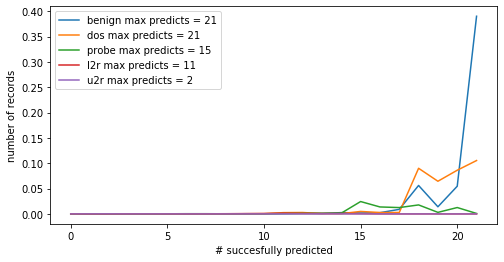

In [201]:
# get an idea of how many records correctly labelled 
# according to https://www.unb.ca/cic/datasets/nsl.html
# highest possible is 21 out of 7 x 3 ML models

s_tr_benign = train_df.loc[train_df['attack_category']=='benign','success_pred']
s_tr_dos = train_df.loc[train_df['attack_category']=='dos','success_pred']
s_tr_probe = train_df.loc[train_df['attack_category']=='probe','success_pred']
s_tr_l2r = train_df.loc[train_df['attack_category']=='r2l','success_pred']
s_tr_u2r = train_df.loc[train_df['attack_category']=='u2r','success_pred']

s_tr = np.array([s_tr_benign, s_tr_dos, s_tr_probe, s_tr_l2r, s_tr_u2r])
l_t = ['benign', 'dos', 'probe', 'l2r', 'u2r']
i = np.arange(0, 22, 1)
cn_tr = [None]*5
fig, ax = plt.subplots(figsize=(8, 4))

for c in range(5):
    cn = np.unique(s_tr[c], return_counts = True)
    tt = [0]*22
    for t in range(len(cn[0])):
        tt[cn[0][t]] = cn[1][t]
    cn_tr[c] = tt/(np.sum(train_df['attack_category'].value_counts()))
    plt.plot(i, np.array(tt)/len(train_df), label = l_t[c] + ' max predicts = ' + str(np.argmax(tt)))
    
ax.set_xlabel('# succesfully predicted')
ax.set_ylabel('number of records')
plt.legend()
plt.show()

In [202]:
# drop the success_pred column
train_df.drop(['success_pred'], axis=1, inplace=True)
test_df.drop(['success_pred'], axis=1, inplace=True)

In [203]:
train_attack_types = train_df['attack_type'].value_counts()
train_attack_cats = train_df['attack_category'].value_counts()
train_attack_cats_P = np.round(train_attack_cats / np.sum(train_attack_cats)*100, 2)

test_attack_types = test_df['attack_type'].value_counts()
test_attack_cats = test_df['attack_category'].value_counts()
test_attack_cats_P = np.round(test_attack_cats / np.sum(test_attack_cats)*100, 2)

dataSummary = pd.DataFrame(data = [train_attack_cats.astype(int), train_attack_cats_P, test_attack_cats.astype(int), test_attack_cats_P],
                          index = ['Train #', 'Train %', 'Test #', 'Test %'])
dataSummary['all'] = [np.sum(train_attack_cats), 100, np.sum(test_attack_cats), 100]
dataSummary = dataSummary.transpose()

display(dataSummary)

,Train #,Train %,Test #,Test %
benign,67343.0,53.46,9711.0,43.08
dos,45927.0,36.46,7636.0,33.87
probe,11656.0,9.25,2423.0,10.75
r2l,995.0,0.79,2574.0,11.42
u2r,52.0,0.04,200.0,0.89
all,125973.0,100.00,22544.0,100.00


su_attempted
0    125952
1        21
dtype: int64

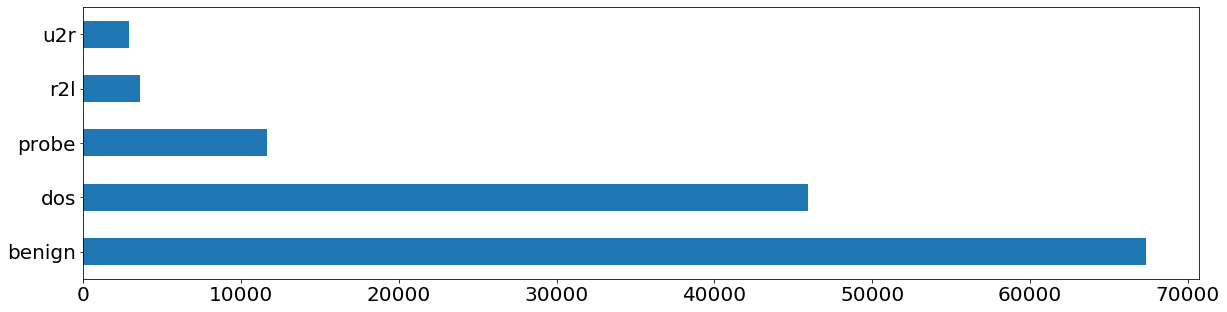

In [9]:
train_attack_types = train_df['attack_type'].value_counts()
train_attack_cats = train_df['attack_category'].value_counts()

test_attack_types = test_df['attack_type'].value_counts()
test_attack_cats = test_df['attack_category'].value_counts()

train_attack_types.plot(kind='barh', figsize=(20,5), fontsize=10)

train_attack_cats.plot(kind='barh', figsize=(20,5), fontsize=20)

train_df[binary_cols].describe().transpose()
train_df.groupby(['su_attempted']).size()
train_df['su_attempted'].replace(2, 0, inplace=True)
test_df['su_attempted'].replace(2, 0, inplace=True)
train_df.groupby(['su_attempted']).size()

if 'num_outbound_cmds' in train_df.columns:
    train_df.groupby(['num_outbound_cmds']).size()

    #Now, that's not a very useful feature - let's drop it from the dataset

    train_df.drop('num_outbound_cmds', axis = 1, inplace=True)
    test_df.drop('num_outbound_cmds', axis = 1, inplace=True)
    numeric_cols.remove('num_outbound_cmds')



#Data Preparation

train_Y = train_df['attack_category']
train_x_raw = train_df.drop(['attack_category','attack_type'], axis=1)
test_Y = test_df['attack_category']
test_x_raw = test_df.drop(['attack_category','attack_type'], axis=1)


combined_df_raw = pd.concat([train_x_raw, test_x_raw])
combined_df = pd.get_dummies(combined_df_raw, columns=nominal_cols, drop_first=True)

train_x = combined_df[:len(train_x_raw)]
test_x = combined_df[len(train_x_raw):]

# Store dummy variable feature names
dummy_variables = list(set(train_x)-set(combined_df_raw))

#execute the commands in console
train_x.describe()
train_x['duration'].describe()
# Experimenting with StandardScaler on the single 'duration' feature
from sklearn.preprocessing import StandardScaler

durations = train_x['duration'].values.reshape(-1, 1)
standard_scaler = StandardScaler().fit(durations)
scaled_durations = standard_scaler.transform(durations)
pd.Series(scaled_durations.flatten()).describe()

# Experimenting with MinMaxScaler on the single 'duration' feature
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler().fit(durations)
min_max_scaled_durations = min_max_scaler.transform(durations)
pd.Series(min_max_scaled_durations.flatten()).describe()

# Experimenting with RobustScaler on the single 'duration' feature
from sklearn.preprocessing import RobustScaler

min_max_scaler = RobustScaler().fit(durations)
robust_scaled_durations = min_max_scaler.transform(durations)
pd.Series(robust_scaled_durations.flatten()).describe()

# Experimenting with MaxAbsScaler on the single 'duration' feature
from sklearn.preprocessing import MaxAbsScaler

max_Abs_scaler = MaxAbsScaler().fit(durations)
robust_scaled_durations = max_Abs_scaler.transform(durations)
pd.Series(robust_scaled_durations.flatten()).describe()

# Let's proceed with StandardScaler- Apply to all the numeric columns

standard_scaler = StandardScaler().fit(train_x[numeric_cols])

train_x[numeric_cols] = \
    standard_scaler.transform(train_x[numeric_cols])

test_x[numeric_cols] = \
    standard_scaler.transform(test_x[numeric_cols])
    
display(train_x.describe())

__Question 4.1__

In [206]:
feature_names = list(train_x.columns)
print(feature_names)

['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'protocol_type_tcp', 'protocol_type_udp', 'service_X11', 'service_Z39_50', 'service_aol', 'service_auth', 'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf', 'service_daytime', 'service_discard', 'service_domain', 'service_domain_u', 'service_echo', 'service_eco_i', 'service_ecr_i', 'service_efs', 'service_exe

__Question 4.2__

In [207]:
print("Train data set length:", len(train_x))
print("Test data set length:", len(test_x))
print("Ratio of test to train:",len(test_x)/len(train_x))

Train data set length: 125973
Test data set length: 22544
Ratio of test to train: 0.17895898327419368


__Question 4.3__

In [208]:
ac_train_counts = np.unique(np.array(train_df['attack_category']), return_counts=True)
ac_train = pd.DataFrame(columns = ['train'], index=ac_train_counts[0], data = ac_train_counts[1])
ac_train = ac_train.transpose()

ac_test_counts = np.unique(np.array(test_df['attack_category']), return_counts=True)
ac_test = pd.DataFrame(columns = ['test'], index=ac_test_counts[0], data = ac_test_counts[1])
ac_test = ac_test.transpose()

class_names = ac_train.columns


print('Target classes:', list(class_names))

ac_train['total'] = ac_train.values.sum()
ac_test['total'] = ac_test.values.sum()
display(ac_train)
display(ac_test)

Target classes: ['benign', 'dos', 'probe', 'r2l', 'u2r']


,benign,dos,probe,r2l,u2r,total
train,67343,45927,11656,995,52,125973


,benign,dos,probe,r2l,u2r,total
test,9711,7636,2423,2574,200,22544


In [209]:
# just changing names
X_train = train_x.copy()
X_test = test_x.copy()

y_train = train_Y.copy()
y_test = test_Y.copy()

__Some feature exploration using PCA__

In [ ]:
from sklearn.decomposition import PCA

num_components = len(train_x.columns)
pca_dimensions = np.arange(num_components) + 1
columns_names = ['Components', 'Component Variance', 'Captured Variance']
pca_data = pd.DataFrame(columns = columns_names)
# print(num_components)

pca = PCA(0.99)
pca.fit(train_x)

pca_data['Components'] = pd.Series(pca_dimensions)
pca_data['Component Variance'] = pd.Series(np.round(pca.explained_variance_ratio_, 4))
pca_data['Captured Variance'] = pd.Series(np.round(np.cumsum(pca.explained_variance_ratio_), 4))

plt.plot(pca_data['Components'], pca_data['Component Variance'], label = ['Component Variance'])
plt.plot(pca_data['Components'], pca_data['Captured Variance'], label = ['Captured Variance'])
plt.title('Components vs Captured Variance', size=15, pad=10)
plt.xlabel('Components')
plt.ylabel('Variance')
plt.show()

n_c99 = len(pca.explained_variance_ratio_)-1

print('Number of components for 99% variance: ', n_c99,'=',pca_data['Captured Variance'][n_c99]*100,'%')
print()
# pca_components[idx] = pca_components[idx].set_index('Components ' + n_names[idx])
# pca_components[idx] = pca_components[idx].drop(columns=['Components'])

Flattening points in Z-3-PCA > 2 total: [125528    445]


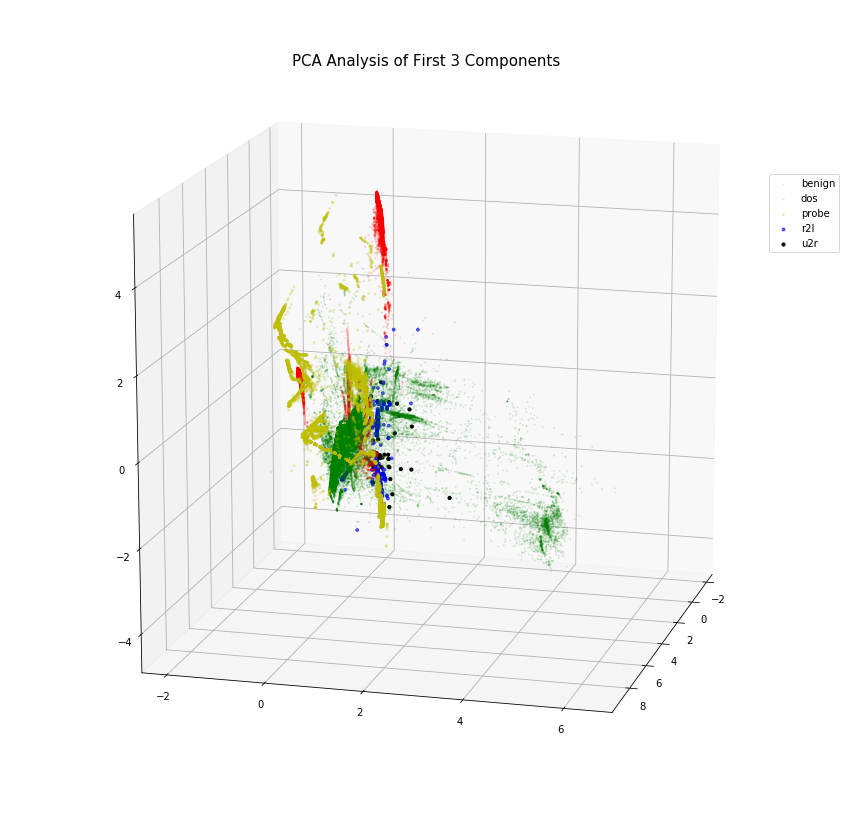

In [509]:
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(3)
pca.fit(X_train)
X_pca = pca.transform(X_train)
benign_idx = (y_train[(y_train == 'benign')]).index
dos_idx    = (y_train[(y_train == 'dos')]).index
probe_idx  = (y_train[(y_train == 'probe')]).index
r2l_idx    = (y_train[(y_train == 'r2l')]).index
u2r_idx    = (y_train[(y_train == 'u2r')]).index

# standard_scaler = StandardScaler().fit(X_pca)
# X_pca = standard_scaler.transform(X_pca)
print('Flattening points in Z-3-PCA > 2 total:', np.unique((X_pca[:, 2] > 2), return_counts=True)[1])
X_pca[:, 2][X_pca[:, 2] > 2] = 0

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_pca[benign_idx, 1], X_pca[benign_idx, 1], X_pca[benign_idx, 0], label = 'benign', s=1,
            alpha=0.1, c = 'g')

ax.scatter(X_pca[dos_idx, 1], X_pca[dos_idx, 2], X_pca[dos_idx, 0], label = 'dos', s=2,
            alpha=0.1, c = 'r')

ax.scatter(X_pca[probe_idx, 1], X_pca[probe_idx, 2], X_pca[probe_idx, 0], label = 'probe', s=4,
            alpha=0.2, c = 'y')

ax.scatter(X_pca[r2l_idx, 1], X_pca[r2l_idx, 2], X_pca[r2l_idx, 0], label = 'r2l', s=8,
            alpha=0.6, c = 'b')

ax.scatter(X_pca[u2r_idx, 1], X_pca[u2r_idx, 2], X_pca[u2r_idx, 0], label = 'u2r', s=10,
            alpha=1.0, c = 'black')

ax.view_init(15, 15)
plt.title('PCA Analysis of First 3 Components', size = 15)
plt.legend(bbox_to_anchor=(1,0.8))
plt.show()

# SECTION 3: Multi class classification
__This is the section where you have to add other algorithms, tune algorithms and visualize to compare and analyze algorithms__

__Question 6.1__

In [22]:
import time
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

__Helper functions for training and testing any classifier and returning summary and individual performance metrics, confusion matrices, etc__

In [23]:
from IPython.display import display_html
def displaysbs(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

# helper function for zipping iterators
def fzip(data):
    return zip(range(len(data)), data)

In [24]:
import time
from sklearn.model_selection import train_test_split

# confusion matrix for multi-class classification based on and modified from post and article 
# https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
# https://towardsdatascience.com/accuracy-recall-precision-f-score-specificity-which-to-optimize-on-867d3f11124
def getResultsTTS(clf, name, X, y, n_repeats = 1, random_state = None, test_size = 0.3):
    
    # create test and train datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, stratify = y, random_state = R)        
    return getResults(clf, name, X_train, X_test, y_train, y_test, n_repeats)
        
def getStats(y_pred, y_test, name):
    
    class_names = np.unique(y_test)

    # calculate confusion matrix for binary or multivariate classification
    cm = metrics.confusion_matrix(y_test, y_pred)
    CM = pd.DataFrame(cm, index = class_names, columns = class_names)

    # calculate TP, TN, FP, FN
    FP = CM.sum(axis=0) - np.diag(CM)  
    FN = CM.sum(axis=1) - np.diag(CM)
    TP = np.diag(CM)
    TN = CM.values.sum() - (FP + FN + TP)

    # calculate accuracy, precision, recall, f1 
    # and false positive rate for each class/es

    I_Accuracy = (TP+TN)/(TP+FP+FN+TN)
    I_Precision = TP/(TP+FP)
    I_Recall = TP/(TP+FN)
    I_F1 = 2*(I_Recall * I_Precision) / (I_Recall + I_Precision)
    I_FPR = FP/(FP+TN)

    # put class by class results in a dataframe
    I_Results = pd.DataFrame(data = [I_Accuracy, I_Precision, I_Recall, I_F1, I_FPR],
                            index = ['Accuracy', 'Precision', 'Recall', 'F1', 'FPR'],
                            columns = class_names).transpose()


    # calculate weighted accuracy, precision, recall, f1 
    # and false positive rate for each class/es

    support = np.unique(y_test, return_counts=True)[1]
    weights = support/support.sum()

    S_Accuracy = metrics.accuracy_score(y_test, y_pred)
    B_Accuracy = metrics.balanced_accuracy_score(y_test, y_pred)
    S_Precision = metrics.precision_score(y_test, y_pred, average='weighted')
    S_Recall = metrics.recall_score(y_test, y_pred, average='weighted')
    S_F1 = metrics.f1_score(y_test, y_pred, average='weighted')

    W_Accuracy = (I_Accuracy * weights).sum()
    W_FPR = (I_FPR * weights).sum()

    # put weighted overall results in a dataframe
    S_Results = pd.DataFrame(data = [[S_Accuracy, S_Precision, S_Recall, S_F1, W_FPR, 0, 0, W_Accuracy, B_Accuracy]],
                            columns = ['Accuracy', 'Precision', 'Recall', 'F1', 'FPR', 'TR Time', 'PR Time', 'W_Accuracy', 'B_Accuracy'],
                            index = [name])

    return I_Results, S_Results, CM
               
def getResults(clf, name, X_train, X_test, y_train, y_test, n_repeats = 1):
    
    # iterate predictions if requested
    for s in range(n_repeats):
        
        # time fitting the model
        start_TR = time.perf_counter()
#         if b_skipfit == False:
        clf = clf.fit(X_train, y_train)    
        end_TR = time.perf_counter()
        
        # time predicting with the model
        start_PR = time.perf_counter()
#         if b_gridsearch == True:
#             y_pred = clf.best_estimator_.predict(X_test) # if doing a GridSearch
#         else:    
        y_pred = clf.predict(X_test) # or normally
        end_PR = time.perf_counter()

        I_Results, S_Results, CM = getStats(y_pred, y_test, name)
        
        S_TimeTR = end_TR - start_TR
        S_TimePR = end_PR - start_PR
        
        S_Results['TR Time'] = S_TimeTR
        S_Results['PR Time'] = S_TimePR

        if s == 0:
            IT_Results = I_Results
            ST_Results = S_Results
            CMT        = CM
        else:
            IT_Results = IT_Results + I_Results
            ST_Results = ST_Results + S_Results
            CMT        = CMT + CM
    
    # sanity check
    #print(metrics.classification_report(y_test, y_pred))
    
    # average results
    I_Results = IT_Results / n_repeats
    S_Results = ST_Results / n_repeats
    CM        = (CMT / n_repeats).astype(int)

    return I_Results, S_Results, CM

def roundResults(I_Results, S_Results):
    
    pct_cols = ['Accuracy', 'Precision', 'Recall', 'F1', 'FPR', 'W_Accuracy', 'B_Accuracy']
    
    I_Results = np.round(I_Results, 4) * 100
    S_Results = np.round(S_Results, 4)
    
    S_Results[pct_cols] = S_Results[pct_cols] * 100
    
    return I_Results, S_Results
    

In [25]:
def showResultsBA(clf, name):
    
    results = pd.DataFrame(clf.cv_results_)
    
    rank_col = [col for col in results if col.startswith('rank_test_')]
    mean_col = [col for col in results if col.startswith('mean_test')]
    
    results[mean_col] = np.round(results[mean_col]*100, 2)
    results[['mean_fit_time', 'mean_score_time']] = np.round(results[['mean_fit_time', 'mean_score_time']], 2)
    
    mean_col = mean_col + ['mean_fit_time', 'mean_score_time']
    rank_col.append('params')
    all_col = rank_col + mean_col
    
    pd_cols = ['Accuracy', 'bAccuracy', 'Precision', 'Recall', 'F1', 'TR Time', 'PR Time']
    
    bAccIdx = results[results['rank_test_accuracy'] == 1].index[0]
    best_acc = pd.DataFrame(data = [results.iloc[bAccIdx][mean_col].ravel()],
                        index = ['lr-ac-'+name],
                        columns = pd_cols)
    
    print('Best Accuracy')
    display(best_acc)
    display(results.iloc[bAccIdx]['params'])
    
    bBccIdx = results[results['rank_test_balanced_accuracy'] == 1].index[0]
    best_bcc = pd.DataFrame(data = [results.iloc[bBccIdx][mean_col].ravel()],
                            index = ['lr-bc-'+name],
                            columns = pd_cols)

    print('Best Balanced Accuracy')
    display(best_bcc)
    display(results.iloc[bBccIdx]['params'])
    
    return best_acc, best_bcc


# Hyperparameter Tuning

__Scoring methods for model evaluation__

In [26]:
scoring = ('accuracy', 'balanced_accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted')
R = 20031975

__Setup different class weight/decision threshold strategies__

In [27]:
train_attack_cats_PF = train_attack_cats / np.sum(train_attack_cats)
test_attack_cats_PF = test_attack_cats / np.sum(test_attack_cats)

cWeight1MnTS = (1-test_attack_cats_PF).to_dict()
cWeight1MnTR = (1-train_attack_cats_PF).to_dict()
cWeightInvTS = (1/test_attack_cats_PF).to_dict()
cWeightInvTR = (1/train_attack_cats_PF).to_dict()
cWeightHvySI = {'benign':1, 'dos':2, 'probe':20, 'r2l':40, 'u2r':200}

allWeights = [cWeight1MnTR, cWeightInvTR, cWeightHvySI]
allWLabels = ['cWeight1MnTR', 'cWeightInvTR', 'cWeightHvySI']
print(cWeight1MnTR)
print(cWeightInvTR)
print(cWeightHvySI)

# for ensemble/voting models (those don't accept named dict)
cWeight1MnNMB = {0: 0.46541719257301173, 
                 1: 0.6354218761163106, 
                 2: 0.9074722361140879, 
                 3: 0.9921014820636168, 
                 4: 0.9995872131329729}

{'benign': 0.46541719257301173, 'dos': 0.6354218761163106, 'probe': 0.9074722361140879, 'r2l': 0.9921014820636168, 'u2r': 0.9995872131329729}
{'benign': 1.8706175846041906, 'dos': 2.742896335488928, 'probe': 10.807566918325325, 'r2l': 126.60603015075375, 'u2r': 2422.5576923076924}
{'benign': 1, 'dos': 2, 'probe': 20, 'r2l': 40, 'u2r': 200}


## Feature selection exploration using Decision Tree Classifier

__Examine shallow decision tree__

X[1] src_bytes
X[9] num_compromised
X[18] count
X[30] dst_host_diff_srv_rate
X[31] dst_host_same_src_port_rate
X[53] service_ecr_i


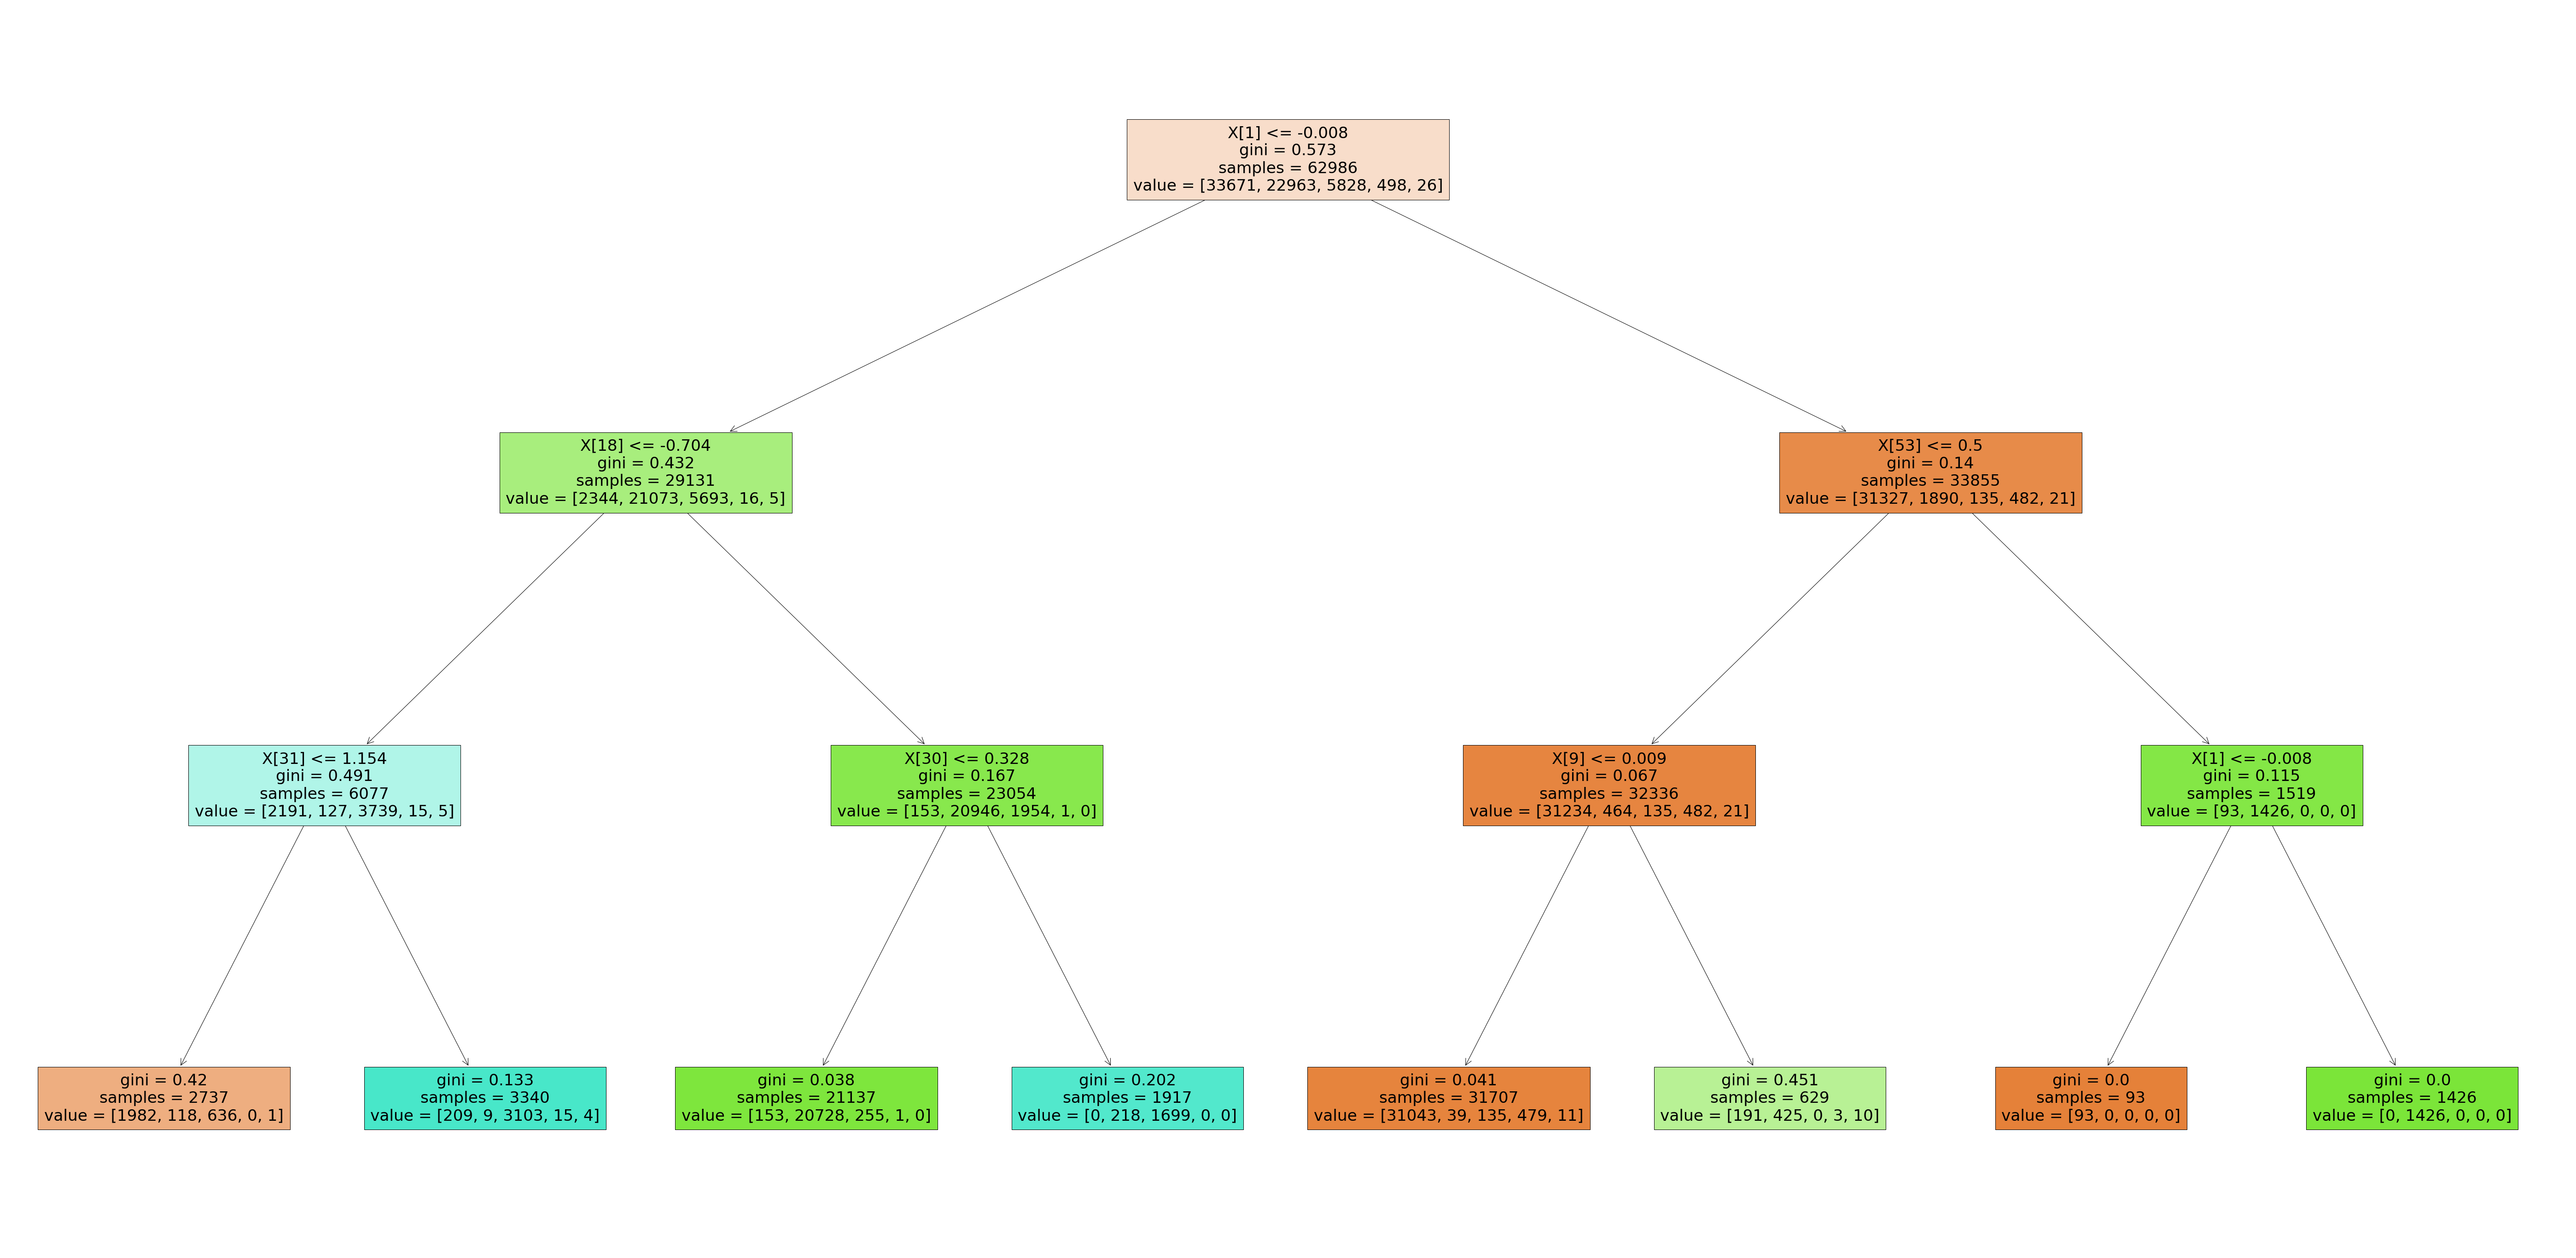

In [220]:
from sklearn import tree
import graphviz

# dtc_exp = DecisionTreeClassifier(max_depth = 3)

# I_Results, S_Results, CM = getResultsTTS(dtc_exp, 'dtc-exp', X_train, y_train, 
#                                          random_state = R, n_repeats = 1, test_size = 0.5)

# dot_data = tree.export_graphviz(dtc_exp, out_file=None) 
# graph = graphviz.Source(dot_data) 
# graph.render("dtcgraph")


for idx, n in fzip(feature_names):
    if dtc_exp.feature_importances_[idx] > 0:
        print('X['+str(idx)+']', feature_names[idx])

plt.figure(figsize=(100,50)) 
tree.plot_tree(dtc_exp,filled=True)
plt.show()

# Incremental Optimal Hyperparameter Search

In [229]:
from matplotlib.ticker import MaxNLocator

def plotACBC(minR, maxR, stepR, acc_scores, bcc_scores, title = '', xlabel = ''):

    i = np.arange(minR, maxR, stepR)

    fig, ax = plt.subplots(figsize=(20, 5))

    aIdx = np.argmax(acc_scores)
    bIdx = np.argmax(bcc_scores)
    
    alabel = 'a-'+''.join([x[0] for x in xlabel.split()])+' = '+str(aIdx * stepR + minR)
    blabel = 'b-'+''.join([x[0] for x in xlabel.split()])+' = '+str(bIdx * stepR + minR)
    
    ax.plot(i, acc_scores, label = alabel)
    ax.plot(i, bcc_scores, label = blabel)

    ax.scatter(aIdx * stepR + minR, acc_scores[aIdx], c = 'g')
    ax.scatter(bIdx * stepR + minR, bcc_scores[bIdx], c = 'r')

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    ax.set_title(title, size = 15, pad = 10)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('b/accuracy')
    ax.legend(loc='upper left')
    plt.show()

In [230]:
graph_repeats = 3

## Decisiont Tree

In [231]:
max_depth = 25
dtc = [None] * 3
acc_dtc = [[0]*max_depth, [0]*max_depth, [0]*max_depth]
bcc_dtc = [[0]*max_depth, [0]*max_depth, [0]*max_depth]

for cIdx, cWeight in fzip(allWeights):
    
    for depth in range(max_depth):
        
        dtc[cIdx] = DecisionTreeClassifier(class_weight = cWeight, max_depth = depth + 5)
        _, S_Results, _ = getResultsTTS(dtc[cIdx], 'DTC', X_train, y_train,
                                        random_state = R, n_repeats = graph_repeats, test_size = 0.5)
        
        acc_dtc[cIdx][depth] = S_Results.iloc[0]['Accuracy']
        bcc_dtc[cIdx][depth] = S_Results.iloc[0]['B_Accuracy']

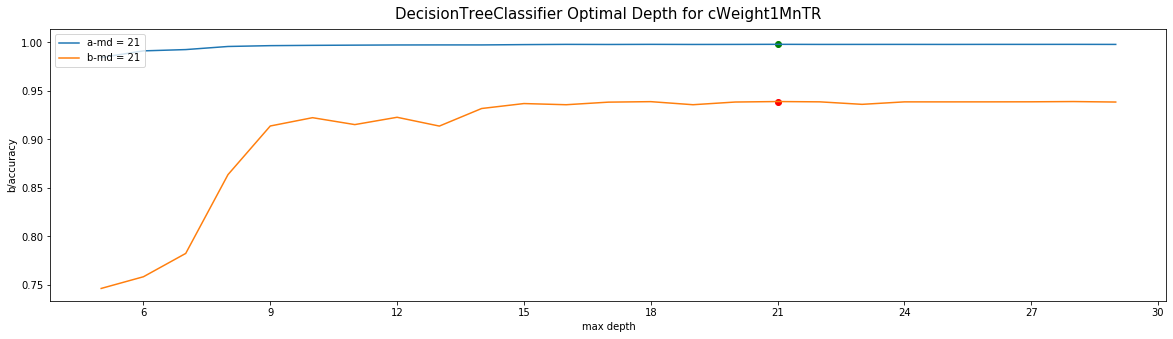

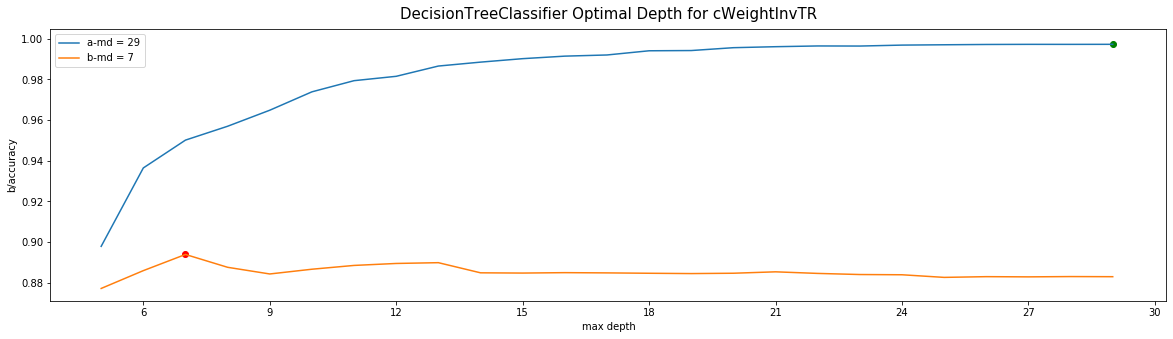

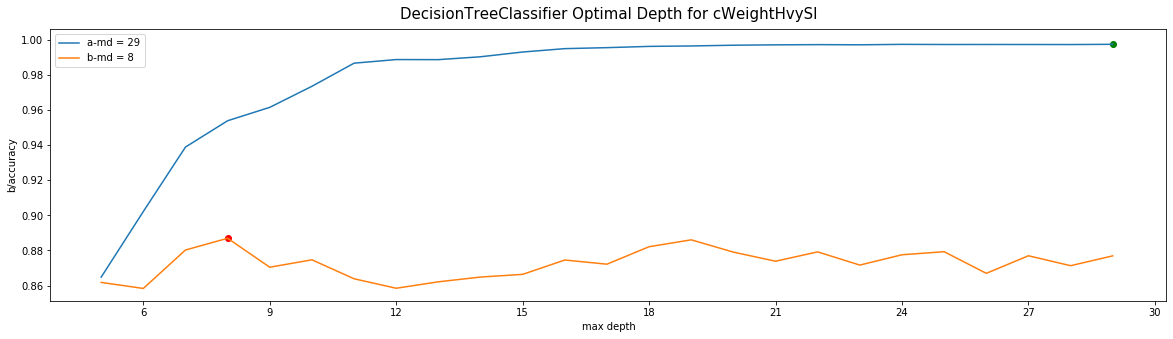

In [788]:
for cIdx, wLabel in fzip(allWLabels):
    title = 'DecisionTreeClassifier Optimal Depth for ' + wLabel
    plotACBC(5, 30, 1, acc_dtc[cIdx], bcc_dtc[cIdx], title, 'max depth') 

In [232]:
r = range(8, 126, 11)
acc_dftr = [0]*len(r)
bcc_dftr = [0]*len(r)
idx = 0
for features in r:
    
    dtc_ftr = DecisionTreeClassifier(class_weight = cWeight1MnTR, max_depth = 22, max_features = features)
    _, S_Results, _ = getResultsTTS(dtc_ftr, 'DTC', X_train, y_train,
                                    random_state = R, n_repeats = graph_repeats, test_size = 0.5)
    
    acc_dftr[idx] = S_Results.iloc[0]['Accuracy']
    bcc_dftr[idx] = S_Results.iloc[0]['B_Accuracy']
    idx += 1

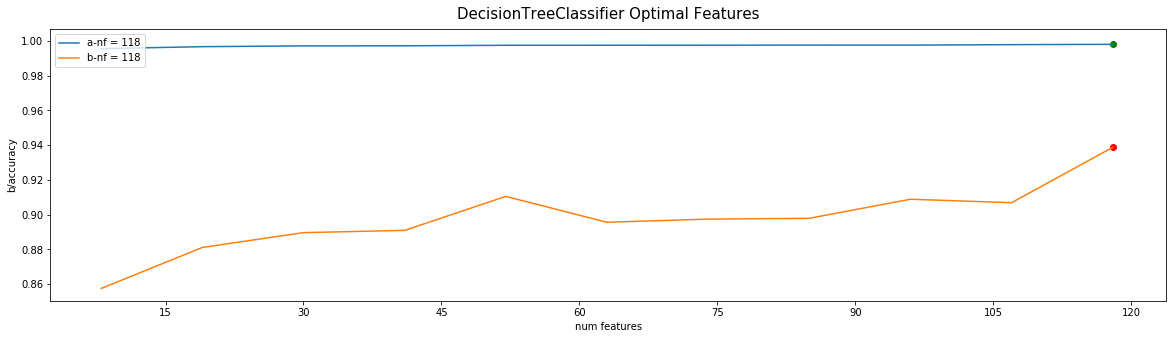

In [790]:
plotACBC(8, 126, 11, acc_dftr, bcc_dftr, 'DecisionTreeClassifier Optimal Features', 'num features')

## Extra Tree

In [233]:
r = range(10, 85, 5)
acc_etc = [0] * len(r)
bcc_etc = [0] * len(r)
idx = 0
for depth in r:
        
    etc_exp = ExtraTreesClassifier(class_weight = cWeight1MnTR, max_depth = depth)
    _, S_Results, _ = getResultsTTS(etc_exp, 'ETC', X_train, y_train,
                                    random_state = R, n_repeats = graph_repeats, test_size = 0.5)

    acc_etc[idx] = S_Results.iloc[0]['Accuracy']
    bcc_etc[idx] = S_Results.iloc[0]['B_Accuracy']  
    idx += 1

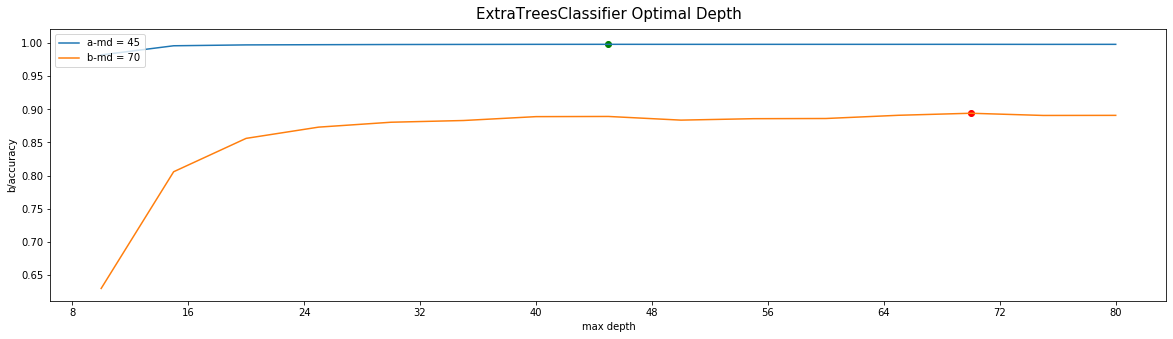

In [792]:
plotACBC(10, 85, 5, acc_etc, bcc_etc, 'ExtraTreesClassifier Optimal Depth', 'max depth')

In [234]:
r = range(10, 150, 10)
acc_etcnm = [0]*len(r)
bcc_etcnm = [0]*len(r)
idx = 0
for estimators in r:
        
    etc_exp = ExtraTreesClassifier(class_weight = cWeight1MnTR, max_depth = 28, n_estimators = estimators)
    _, S_Results, _ = getResultsTTS(etc_exp, 'ETC', X_train, y_train,
                                    random_state = R, n_repeats = graph_repeats, test_size = 0.5)

    acc_etcnm[idx] = S_Results.iloc[0]['Accuracy']
    bcc_etcnm[idx] = S_Results.iloc[0]['B_Accuracy'] 
    idx += 1

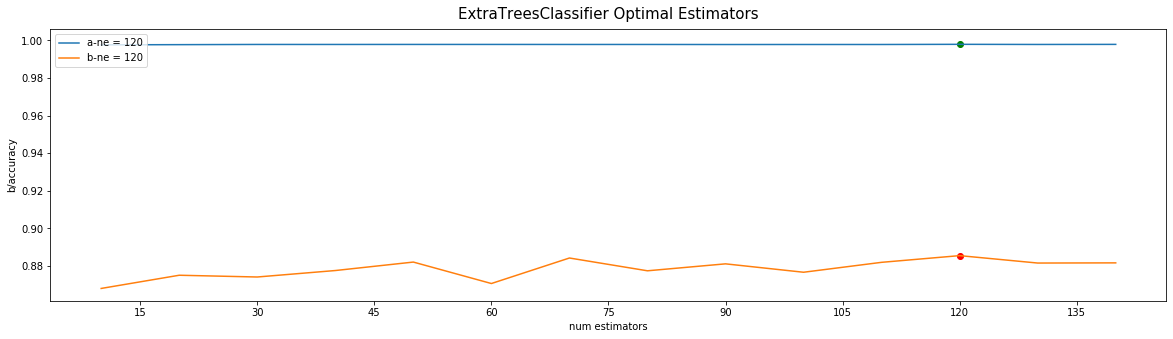

In [794]:
plotACBC(10, 150, 10, acc_etcnm, bcc_etcnm, 'ExtraTreesClassifier Optimal Estimators', 'num estimators')

In [235]:
r = range(8, 126, 11)
acc_eftr = [0]*len(r)
bcc_eftr = [0]*len(r)
idx = 0
for features in r:
        
    etc_exp = ExtraTreesClassifier(class_weight = cWeight1MnTR, max_depth = 28, 
                                   n_estimators = 90, max_features = features)
    
    _, S_Results, _ = getResultsTTS(etc_exp, 'ETC', X_train, y_train,
                                    random_state = R, n_repeats = graph_repeats, test_size = 0.5)

    acc_eftr[idx] = S_Results.iloc[0]['Accuracy']
    bcc_eftr[idx] = S_Results.iloc[0]['B_Accuracy'] 
    idx += 1

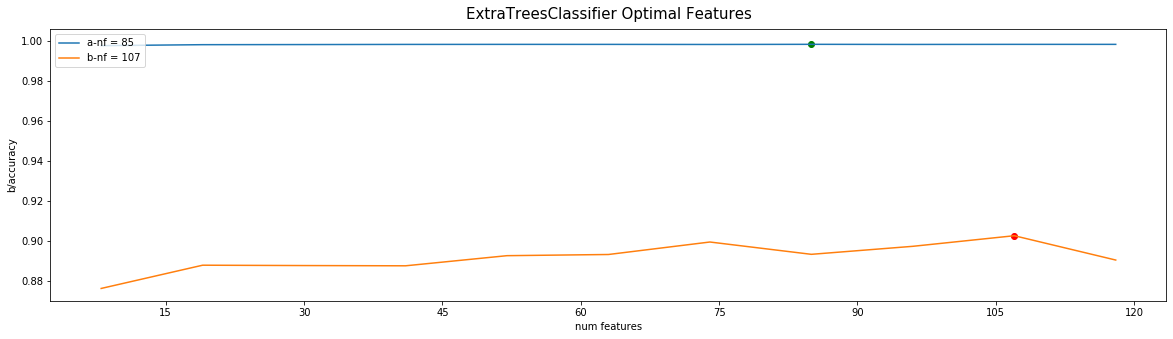

In [796]:
plotACBC(8, 126, 11, acc_eftr, bcc_eftr, 'ExtraTreesClassifier Optimal Features', 'num features')

## Random Forest

In [236]:
r = range(10, 85, 5)
acc_rfc = [0] * len(r)
bcc_rfc = [0] * len(r)
idx = 0

for depth in r:

    rfc_exp = RandomForestClassifier(class_weight = cWeight1MnTR, max_depth = depth, n_jobs = -1)
    _, S_Results, _ = getResultsTTS(rfc_exp, 'RFC', X_train, y_train,
                                    random_state = R, n_repeats = graph_repeats, test_size = 0.5)

    acc_rfc[idx] = S_Results.iloc[0]['Accuracy']
    bcc_rfc[idx] = S_Results.iloc[0]['B_Accuracy']  
    idx += 1

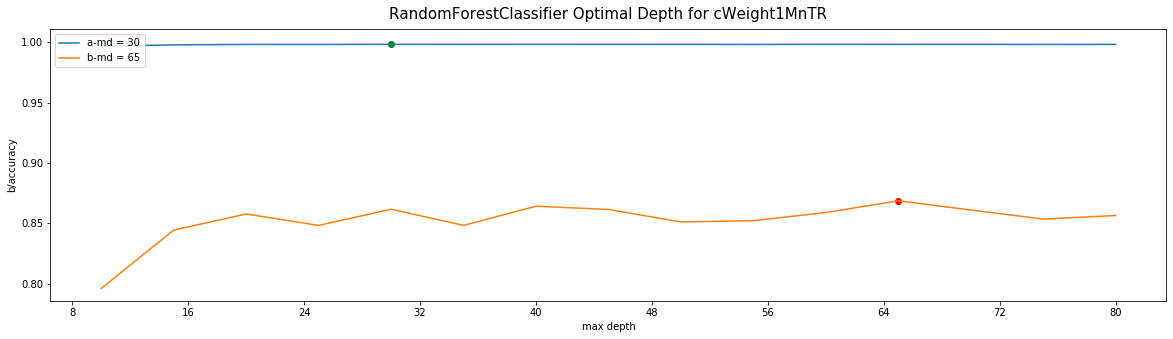

In [798]:
plotACBC(10, 85, 5, acc_rfc, bcc_rfc, 'RandomForestClassifier Optimal Depth for cWeight1MnTR', 'max depth')

In [237]:
r = range(10, 85, 5)
acc_rfc = [0] * len(r)
bcc_rfc = [0] * len(r)
idx = 0

for depth in r:

    rfc_exp = RandomForestClassifier(class_weight = 'balanced_subsample', max_depth = depth, n_jobs = -1)
    _, S_Results, _ = getResultsTTS(rfc_exp, 'RFC', X_train, y_train,
                                    random_state = R, n_repeats = graph_repeats, test_size = 0.5)

    acc_rfc[idx] = S_Results.iloc[0]['Accuracy']
    bcc_rfc[idx] = S_Results.iloc[0]['B_Accuracy']  
    idx += 1

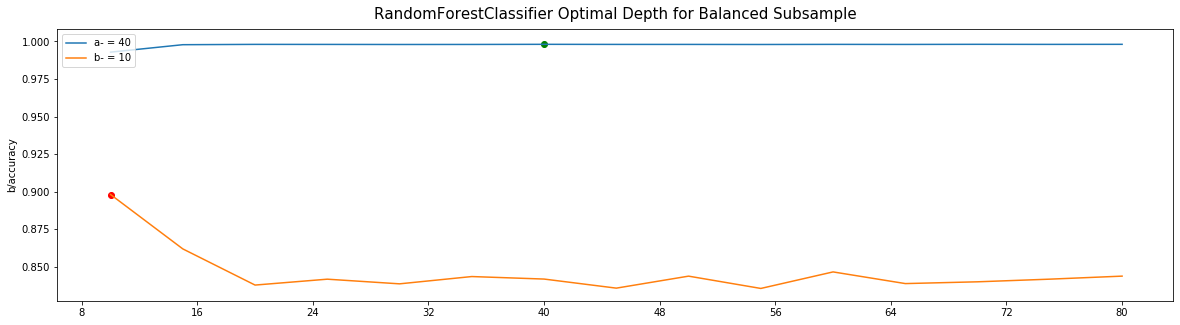

In [800]:
plotACBC(10, 85, 5, acc_rfc, bcc_rfc, 'RandomForestClassifier Optimal Depth for Balanced Subsample')

In [238]:
r = range(10, 150, 10)
acc_rfcnm = [0]*len(r)
bcc_rfcnm = [0]*len(r)
idx = 0
for estimators in r:
        
    rfc_exp = RandomForestClassifier(class_weight = cWeight1MnTR, max_depth = 40, 
                                     n_estimators = estimators, n_jobs = -1)
    _, S_Results, _ = getResultsTTS(rfc_exp, 'RFC', X_train, y_train,
                                    random_state = R, n_repeats = graph_repeats, test_size = 0.5)

    acc_rfcnm[idx] = S_Results.iloc[0]['Accuracy']
    bcc_rfcnm[idx] = S_Results.iloc[0]['B_Accuracy'] 
    idx += 1

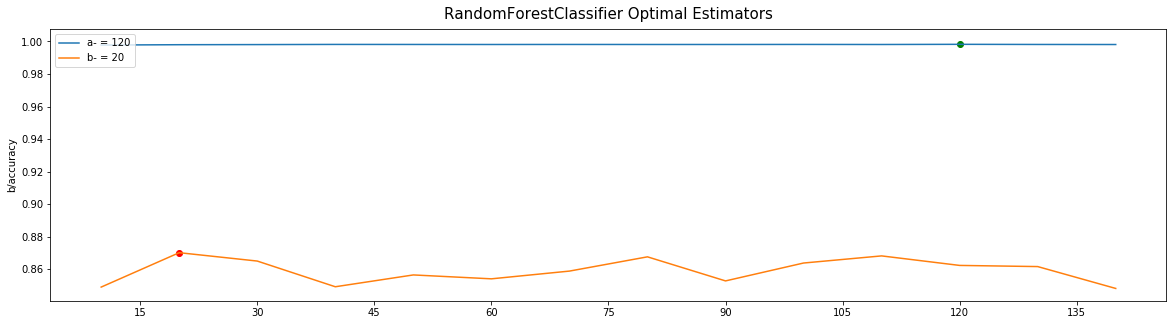

In [802]:
plotACBC(10, 150, 10, acc_rfcnm, bcc_rfcnm, 'RandomForestClassifier Optimal Estimators')

In [239]:
r = range(8, 126, 11)
acc_rftr = [0]*len(r)
bcc_rftr = [0]*len(r)
idx = 0
for features in r:
        
    rfc_exp = RandomForestClassifier(class_weight = cWeight1MnTR, max_depth = 40, 
                                     n_estimators = 10, max_features = features)
    
    _, S_Results, _ = getResultsTTS(rfc_exp, 'RFC', X_train, y_train,
                                    random_state = R, n_repeats = graph_repeats, test_size = 0.5)

    acc_rftr[idx] = S_Results.iloc[0]['Accuracy']
    bcc_rftr[idx] = S_Results.iloc[0]['B_Accuracy'] 
    idx += 1

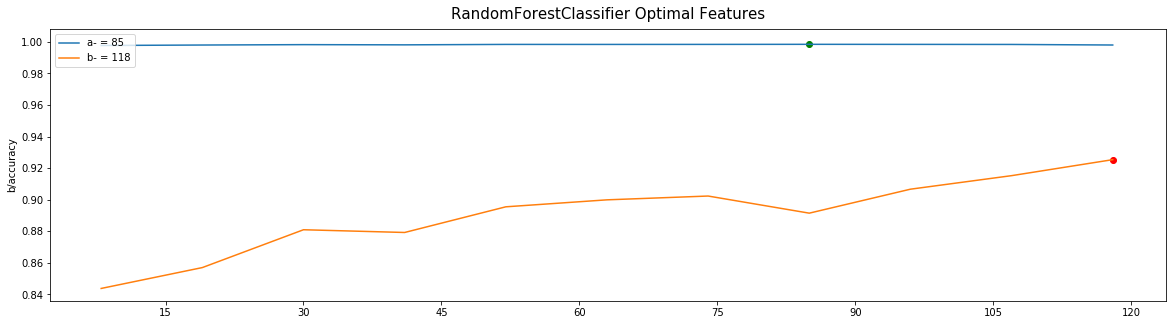

In [804]:
plotACBC(8, 126, 11, acc_rftr, bcc_rftr, 'RandomForestClassifier Optimal Features')

## Logistic Regression

In [240]:
r = range(1, 32, 2)
acc_lrC = [0]*len(r)
bcc_lrC = [0]*len(r)
idx = 0
for C in r:
        
    lrg_exp = LogisticRegression(class_weight = cWeight1MnTR, C = C)
    
    _, S_Results, _ = getResultsTTS(lrg_exp, 'LRG', X_train, y_train,
                                    random_state = R, n_repeats = graph_repeats, test_size = 0.5)

    acc_lrC[idx] = S_Results.iloc[0]['Accuracy']
    bcc_lrC[idx] = S_Results.iloc[0]['B_Accuracy'] 
    idx += 1

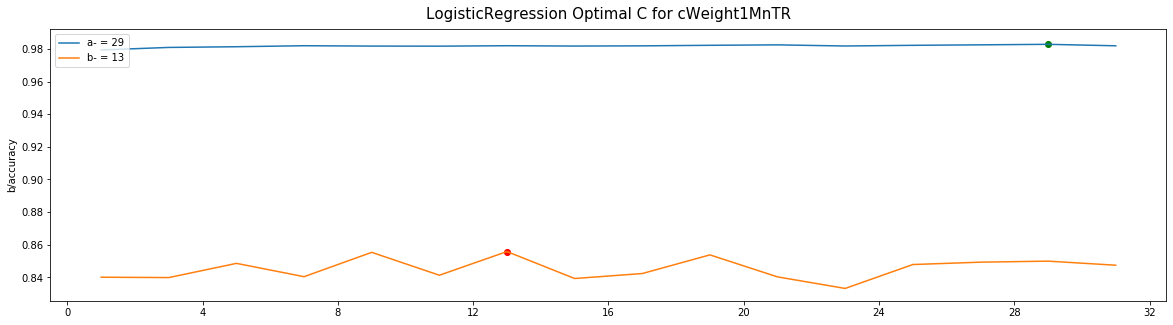

In [810]:
plotACBC(1, 32, 2, acc_lrC, bcc_lrC, 'LogisticRegression Optimal C for cWeight1MnTR')

In [241]:
r = range(6, 32, 2)
acc_lrC = [0]*len(r)
bcc_lrC = [0]*len(r)
idx = 0
for C in r:
        
    lrg_exp = LogisticRegression(class_weight = 'balanced', C = C)
    
    _, S_Results, _ = getResultsTTS(lrg_exp, 'LRG', X_train, y_train,
                                    random_state = R, n_repeats = graph_repeats, test_size = 0.5)

    acc_lrC[idx] = S_Results.iloc[0]['Accuracy']
    bcc_lrC[idx] = S_Results.iloc[0]['B_Accuracy'] 
    idx += 1

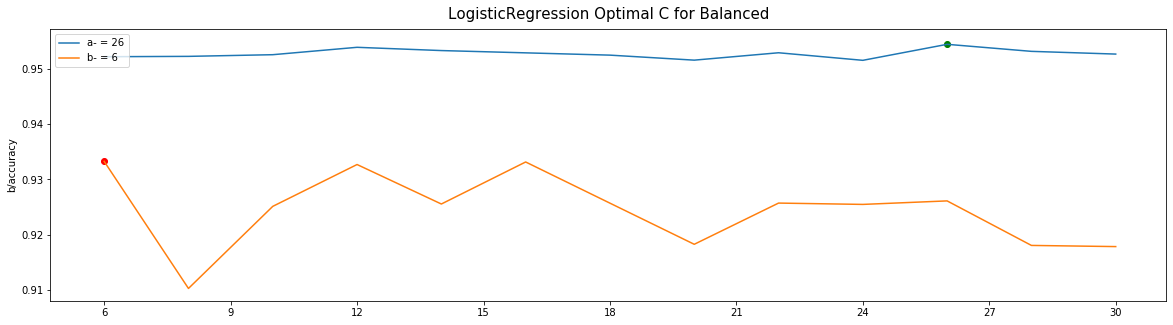

In [808]:
plotACBC(6, 32, 2, acc_lrC, bcc_lrC, 'LogisticRegression Optimal C for Balanced')

# Hyperparamter Gridsearch Optimisation

## DecisionTreeClassifier Hyperparamter Tuning

In [1543]:
name = 'DTC'
params = {
#     'criterion' : ['gini', 'entropy'],
#     'splitter' : ['best', 'random'],
    'max_features' : [118],
    'class_weight' : allWeights,
    'max_depth' : [18, 19, 20, 21, 22, 23, 24],
    }

gsdtc = GridSearchCV(DecisionTreeClassifier(), 
                     params, 
                     refit = False, 
                     scoring = scoring, 
                     n_jobs = -1)

In [1544]:
dtc_acc, dtc_bcc = showResultsBA(gsdtc, 'DTC')

Best Accuracy


,Accuracy,bAccuracy,Precision,Recall,F1,TR Time,PR Time
lr-ac-DTC,99.8,92.53,99.8,99.8,99.8,2.37,0.79


{'class_weight': {'benign': 0.46541719257301173,
  'dos': 0.6354218761163106,
  'probe': 0.9074722361140879,
  'r2l': 0.9921014820636168,
  'u2r': 0.9995872131329729},
 'max_depth': 20,
 'max_features': 118}

Best Balanced Accuracy


,Accuracy,bAccuracy,Precision,Recall,F1,TR Time,PR Time
lr-bc-DTC,99.8,92.53,99.8,99.8,99.8,2.37,0.79


{'class_weight': {'benign': 0.46541719257301173,
  'dos': 0.6354218761163106,
  'probe': 0.9074722361140879,
  'r2l': 0.9921014820636168,
  'u2r': 0.9995872131329729},
 'max_depth': 20,
 'max_features': 118}

## ExtraTreesClassifier Hyperparamter Tuning

In [1545]:
name = 'ETC'
params = {
#     'criterion' : ['gini', 'entropy'],
#     'splitter' : ['best', 'random'],
    'n_estimators' : [90],
    'max_features' : [30, 45, 60],
    'class_weight' : [cWeight1MnTR], #'balanced', None, 
    'max_depth' : [30, 50, 80]
    }

gsetc = GridSearchCV(ExtraTreesClassifier(), 
                     params, 
                     refit = False, 
                     scoring = scoring, 
                     n_jobs = -1)

In [1546]:
etc_acc, etc_bcc = showResultsBA(gsetc, 'ETC')

Best Accuracy


,Accuracy,bAccuracy,Precision,Recall,F1,TR Time,PR Time
lr-ac-ETC,99.88,90.65,99.87,99.88,99.87,52.1,0.83


{'class_weight': {'benign': 0.46541719257301173,
  'dos': 0.6354218761163106,
  'probe': 0.9074722361140879,
  'r2l': 0.9921014820636168,
  'u2r': 0.9995872131329729},
 'max_depth': 80,
 'max_features': 60,
 'n_estimators': 90}

Best Balanced Accuracy


,Accuracy,bAccuracy,Precision,Recall,F1,TR Time,PR Time
lr-bc-ETC,99.87,91.75,99.87,99.87,99.87,49.47,1.62


{'class_weight': {'benign': 0.46541719257301173,
  'dos': 0.6354218761163106,
  'probe': 0.9074722361140879,
  'r2l': 0.9921014820636168,
  'u2r': 0.9995872131329729},
 'max_depth': 50,
 'max_features': 30,
 'n_estimators': 90}

## RandomForestClassifier Hyperparamter Tuning

In [10]:
name = 'RFC'
params = {
    'n_estimators' : [10, 60],#np.arange(10,210,20)
#     'criterion' : ['gini', 'entropy'],
    'max_features' : [63, 107],
    'class_weight' : [cWeight1MnTR], #'balanced', 'balanced_subsample', 
    'max_depth' : [10, 35]#np.arange(1000, 5000, 1000)
    }

gsrfc = GridSearchCV(RandomForestClassifier(), 
                     params,
                     refit = False, 
                     scoring = scoring, 
                     #verbose = 1,
                     n_jobs = -1)

In [11]:
rfc_acc, rfc_bcc = showResultsBA(gsrfc, 'RFC')

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

## LogisticRegression Hyperparamter Tuning

In [45]:
name = 'LRG'
params = {
    'class_weight' : ['balanced', cWeight1MnTR], #['balanced', cWeight1MnTR, cWeightInvTR, cWeightHvySI],
    'C' : [15, 16, 17, 18, 19, 20, 21],
#     'solver' : ['newton-cg', 'liblinear', 'lbfgs','saga']
    }

gslrg = GridSearchCV(LogisticRegression(), 
                     params, 
                     refit = False, 
                     scoring = scoring, 
                     n_jobs = -1)

In [47]:
lrg_acc, lrg_bcc = showResultsBA(gslrg, 'LRG')

Best Accuracy


,Accuracy,bAccuracy,Precision,Recall,F1,TR Time,PR Time
lr-ac-LRG,98.29,85.2,98.33,98.29,98.3,17.8,1.12


{'C': 20,
 'class_weight': {'benign': 0.46541719257301173,
  'dos': 0.6354218761163106,
  'probe': 0.9074722361140879,
  'r2l': 0.9921014820636168,
  'u2r': 0.9995872131329729}}

Best Balanced Accuracy


,Accuracy,bAccuracy,Precision,Recall,F1,TR Time,PR Time
lr-bc-LRG,95.34,91.52,97.25,95.34,96.07,15.36,1.04


{'C': 16, 'class_weight': 'balanced'}

## MLPClassifier Hyperparamter Tuning

In [625]:
name = 'MLP'
params = {
    'hidden_layer_sizes' : [(256, 128, 64, 32), (64, 32, 16)], #(512, 256, 128
    'alpha' : [0.0001, 0.001, 0.01],
#     'activation' : ['tanh', 'relu']  #identity', 'logistic', '
#     'solver' : ['lbfgs', 'sgd'],
#     'learning_rate' : ['invscaling', 'adaptive']
    }

gsmlp = GridSearchCV(MLPClassifier(), 
                     params,
                     refit = False, 
                     scoring = scoring, 
                     n_jobs = -1)

In [627]:
mlp_acc, mlp_bcc = showResultsBA(gsmlp, 'MLP')

Best Accuracy


,Accuracy,bAccuracy,Precision,Recall,F1,TR Time,PR Time
lr-ac-MLP,99.7,89.09,99.7,99.7,99.69,1297.19,3.9


{'alpha': 0.0001, 'hidden_layer_sizes': (256, 128, 64, 32)}

Best Balanced Accuracy


,Accuracy,bAccuracy,Precision,Recall,F1,TR Time,PR Time
lr-bc-MLP,99.67,90.29,99.67,99.67,99.66,1038.55,2.93


{'alpha': 0.001, 'hidden_layer_sizes': (256, 128, 64, 32)}

## KNeighborsClassifier Hyperparamter Tuning

In [606]:
name = 'KNN'
params = {
    'n_neighbors' : [2, 4, 8],
    'weights' : ['distance'] #'uniform', 
#     'leaf_size' : [15, 30, 45]#,
#     'algorithm' : ['ball_tree', 'kd_tree']
    }

gsknn = GridSearchCV(KNeighborsClassifier(), 
                     params,
                     refit = False, 
                     scoring = scoring, 
                     n_jobs = -1)

In [623]:
knn_acc, knn_bcc = showResultsBA(gsknn, 'KNN')

Best Accuracy


,Accuracy,bAccuracy,Precision,Recall,F1,TR Time,PR Time
lr-ac-KNN,99.69,90.18,99.69,99.69,99.69,76.34,296.7


{'n_neighbors': 2, 'weights': 'distance'}

Best Balanced Accuracy


,Accuracy,bAccuracy,Precision,Recall,F1,TR Time,PR Time
lr-bc-KNN,99.69,90.18,99.69,99.69,99.69,76.34,296.7


{'n_neighbors': 2, 'weights': 'distance'}

## AdaBoostClassifier Hyperparamter Tuning

In [50]:
name = 'ADB'
params = {
    'n_estimators' : [150],#200 This needs proper testing but takes a loooong time
    #'algorithm' : ['SAMME.R', 'SAMME']
    'base_estimator' : [DecisionTreeClassifier(class_weight = cWeight1MnNMB, max_depth = 20, max_features = 118),
                        DecisionTreeClassifier(class_weight = 'balanced', max_depth = 20, max_features = 118)]
    }

gsadb = GridSearchCV(AdaBoostClassifier(), 
                     params,
                     refit = False, 
                     scoring = scoring, 
                     n_jobs = -1)

In [51]:
adb_acc, adb_bcc = showResultsBA(gsadb, 'ADB')

Best Accuracy


,Accuracy,bAccuracy,Precision,Recall,F1,TR Time,PR Time
lr-ac-ADB,99.9,87.62,99.9,99.9,99.9,238.08,3.13


{'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                        max_depth=20, max_features=118, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best'),
 'n_estimators': 150}

Best Balanced Accuracy


,Accuracy,bAccuracy,Precision,Recall,F1,TR Time,PR Time
lr-bc-ADB,99.9,87.62,99.9,99.9,99.9,238.08,3.13


{'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                        max_depth=20, max_features=118, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best'),
 'n_estimators': 150}

## GradientBoostingClassifier Hyperparamter Tuning

In [ ]:
name = 'GDB'
params = [
    {
#     'learning_rate' : [0.06, 0.12], # This needs proper investigation but takes way toooo loooooonggg
    'n_estimators' : [100, 200],
#     'subsample' : [0.5, 0.9],
#     'max_depth' : [3, 6],
    'init' : [LogisticRegression(C=16, class_weight = 'balanced')],
    }
]

gsgdb = GridSearchCV(GradientBoostingClassifier(warm_start = True, verbose = 1), 
                     params,
                     refit = False, 
                     scoring = scoring, 
                     verbose = 1,
                     n_jobs = -1)

In [60]:
gdb_acc, gdb_bcc = showResultsBA(gsgdb, 'GDB')

Best Accuracy


,Accuracy,bAccuracy,Precision,Recall,F1,TR Time,PR Time
lr-ac-GDB,99.49,87.5,99.63,99.49,99.56,342.13,1.81


{'init': LogisticRegression(C=16, class_weight='balanced', dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                    max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 'n_estimators': 100}

Best Balanced Accuracy


,Accuracy,bAccuracy,Precision,Recall,F1,TR Time,PR Time
lr-bc-GDB,99.42,88.49,99.56,99.42,99.48,451.97,1.25


{'init': LogisticRegression(C=16, class_weight='balanced', dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                    max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 'n_estimators': 200}

# Train & Test KDDTest+

In [30]:
def displayResults(I, S, C, b_rounded = True):
    if b_rounded == True:
        I, S = roundResults(I, S)
    displaysbs(I, C)
    display(S)

In [152]:
n_iterations = 10


dtc_acc = DecisionTreeClassifier(class_weight = cWeight1MnTR, max_depth = 22, max_features = 118, random_state = R)
dtc_accI_Results, dtc_accS_Results, dtc_accCM = getResults(dtc_acc, 'ac-DTC', 
                                                           X_train, X_test, y_train, y_test, n_iterations)

displayResults(dtc_accI_Results, dtc_accS_Results, dtc_accCM)



etc_acc = ExtraTreesClassifier(class_weight = cWeight1MnTR, max_depth = 80, 
                               max_features = 60, n_estimators = 90, n_jobs = -1, random_state = R)
etc_accI_Results, etc_accS_Results, etc_accCM = getResults(etc_acc, 'ac-ETC', 
                                                           X_train, X_test, y_train, y_test, n_iterations)

displayResults(etc_accI_Results, etc_accS_Results, etc_accCM)



etc_bcc = ExtraTreesClassifier(class_weight = cWeight1MnTR, max_depth = 50, 
                               max_features = 30, n_estimators = 90, n_jobs = -1, random_state = R)
etc_bccI_Results, etc_bccS_Results, etc_bccCM = getResults(etc_bcc, 'bc-ETC', 
                                                           X_train, X_test, y_train, y_test, n_iterations)

displayResults(etc_bccI_Results, etc_bccS_Results, etc_bccCM)



rfc_acc = RandomForestClassifier(class_weight = cWeight1MnTR, max_depth = 35, 
                                  max_features = 63, n_estimators = 60, n_jobs = -1, random_state = R)
rfc_accI_Results, rfc_accS_Results, rfc_accCM = getResults(rfc_acc, 'ac-RFC', 
                                                           X_train, X_test, y_train, y_test, n_iterations)

displayResults(rfc_accI_Results, rfc_accS_Results, rfc_accCM)



rfc_bcc = RandomForestClassifier(class_weight=cWeight1MnTR, max_depth = 35, 
                                 max_features = 107, n_estimators = 10, n_jobs = -1, random_state = R)
rfc_bccI_Results, rfc_bccS_Results, rfc_bccCM = getResults(rfc_bcc, 'bc-RFC', 
                                                           X_train, X_test, y_train, y_test, n_iterations)

displayResults(rfc_bccI_Results, rfc_bccS_Results, rfc_bccCM)


lrg_acc = LogisticRegression(C = 20, class_weight = cWeight1MnTR, n_jobs = -1, random_state = R)
lrg_accI_Results, lrg_accS_Results, lrg_accCM = getResults(lrg_acc, 'ac-LRG', 
                                                       X_train, X_test, y_train, y_test, n_iterations)

displayResults(lrg_accI_Results, lrg_accS_Results, lrg_accCM)


lrg_bcc = LogisticRegression(C = 16, class_weight = 'balanced', n_jobs = -1, random_state = R)
lrg_bccI_Results, lrg_bccS_Results, lrg_bccCM = getResults(lrg_bcc, 'bc-LRG', 
                                                           X_train, X_test, y_train, y_test, n_iterations)

displayResults(lrg_bccI_Results, lrg_bccS_Results, lrg_bccCM)


mlp_acc = MLPClassifier(alpha = 0.0001, hidden_layer_sizes = (256, 128, 64, 32))
mlp_accI_Results, mlp_accS_Results, mlp_accCM = getResults(mlp_acc, 'ac-MLP', 
                                                           X_train, X_test, y_train, y_test, n_iterations)

displayResults(mlp_accI_Results, mlp_accS_Results, mlp_accCM)


mlp_bcc = MLPClassifier(alpha = 0.001, hidden_layer_sizes = (256, 128, 64, 32))
mlp_bccI_Results, mlp_bccS_Results, mlp_bccCM = getResults(mlp_bcc, 'bc-MLP', 
                                                           X_train, X_test, y_train, y_test, n_iterations)

displayResults(mlp_bccI_Results, mlp_bccS_Results, mlp_bccCM)


gdb_acc = GradientBoostingClassifier(init = LogisticRegression(C=16, class_weight = 'balanced'), 
                                     n_estimators = 100, random_state = R)
gdb_accI_Results, gdb_accS_Results, gdb_accCM = getResults(gdb_acc, 'ac-GDB', 
                                                           X_train, X_test, y_train, y_test, n_iterations)

displayResults(gdb_accI_Results, gdb_accS_Results, gdb_accCM)


gdb_bcc = GradientBoostingClassifier(init = LogisticRegression(C=16, class_weight = 'balanced'), 
                                      n_estimators = 200, random_state = R)
gdb_bccI_Results, gdb_bccS_Results, gdb_bccCM = getResults(gdb_bcc, 'bc-GDB', 
                                                           X_train, X_test, y_train, y_test, n_iterations)

displayResults(gdb_bccI_Results, gdb_bccS_Results, gdb_bccCM)


adb_dtc = AdaBoostClassifier(n_estimators = 150,
                             base_estimator = DecisionTreeClassifier(class_weight = 'balanced', random_state = R,
                                                                     max_depth = 22, max_features = 118))
adb_dtcI_Results, adb_dtcS_Results, adb_dtcCM = getResults(adb_dtc, 'dtc-ADB', 
                                                           X_train, X_test, y_train, y_test, n_iterations)

displayResults(adb_dtcI_Results, adb_dtcS_Results, adb_dtcCM)

knn_acc = KNeighborsClassifier(n_neighbors = 2, weights = 'distance', n_jobs = -1)
knn_accI_Results, knn_accS_Results, knn_accCM = getResults(knn_acc, 'KNN', 
                                                           X_train, X_test, y_train, y_test, n_iterations)

displayResults(knn_accI_Results, knn_accS_Results, knn_accCM)

,Accuracy,Precision,Recall,F1,FPR
benign,82.25,71.79,96.84,82.46,28.79
dos,90.22,95.30,74.83,83.83,1.89
probe,92.91,65.68,71.23,68.34,4.48
r2l,90.38,97.42,16.16,27.72,0.06
u2r,97.52,4.31,8.50,5.72,1.69
,benign,dos,probe,r2l,u2r
benign,9404,71,233,2,1
dos,1690,5714,232,0,0
probe,481,210,1726,4,2
r2l,1455,0,329,416,374


,Accuracy,Precision,Recall,F1,FPR,TR Time,PR Time,W_Accuracy,B_Accuracy
ac-DTC,76.64,81.42,76.64,74.48,13.55,1.9954,0.0195,87.16,53.51


,Accuracy,Precision,Recall,F1,FPR
benign,78.22,67.08,97.08,79.34,36.05
dos,92.46,96.36,80.80,87.90,1.56
probe,95.45,86.18,68.72,76.46,1.33
r2l,89.17,96.50,5.36,10.16,0.03
u2r,99.13,61.54,4.00,7.51,0.02
,benign,dos,probe,r2l,u2r
benign,9427,69,212,1,2
dos,1425,6170,41,0,0
probe,594,164,1665,0,0
r2l,2429,0,4,138,3


,Accuracy,Precision,Recall,F1,FPR,TR Time,PR Time,W_Accuracy,B_Accuracy
ac-ETC,77.22,82.36,77.22,73.39,16.2,20.2197,0.1354,86.33,51.19


,Accuracy,Precision,Recall,F1,FPR
benign,76.41,65.76,94.36,77.51,37.17
dos,91.92,96.30,79.18,86.91,1.56
probe,93.79,73.21,66.53,69.71,2.93
r2l,89.06,95.00,4.43,8.46,0.03
u2r,99.14,72.73,4.00,7.58,0.01
,benign,dos,probe,r2l,u2r
benign,9163,68,476,2,2
dos,1482,6046,108,0,0
probe,647,164,1612,0,0
r2l,2456,0,3,114,1


,Accuracy,Precision,Recall,F1,FPR,TR Time,PR Time,W_Accuracy,B_Accuracy
bc-ETC,75.16,80.31,75.16,71.35,16.86,10.7651,0.1375,85.18,49.7


,Accuracy,Precision,Recall,F1,FPR
benign,77.48,66.27,97.21,78.81,37.44
dos,91.73,96.24,78.67,86.57,1.58
probe,95.14,85.55,65.95,74.48,1.34
r2l,89.34,96.72,6.88,12.84,0.03
u2r,99.12,66.67,2.00,3.88,0.01
,benign,dos,probe,r2l,u2r
benign,9440,70,200,1,0
dos,1564,6007,65,0,0
probe,660,165,1598,0,0
r2l,2392,0,3,177,2


,Accuracy,Precision,Recall,F1,FPR,TR Time,PR Time,W_Accuracy,B_Accuracy
ac-RFC,76.41,81.97,76.41,72.78,16.81,13.1925,0.1391,85.75,50.14


,Accuracy,Precision,Recall,F1,FPR
benign,79.13,68.12,96.87,79.99,34.30
dos,89.80,95.78,73.11,82.93,1.65
probe,92.84,65.47,70.57,67.92,4.48
r2l,89.76,96.82,10.64,19.18,0.05
u2r,99.15,90.91,5.00,9.48,0.00
,benign,dos,probe,r2l,u2r
benign,9407,70,234,0,0
dos,1824,5583,229,0,0
probe,538,175,1710,0,0
r2l,1966,1,332,274,1


,Accuracy,Precision,Recall,F1,FPR,TR Time,PR Time,W_Accuracy,B_Accuracy
bc-RFC,75.34,80.68,75.34,72.12,15.82,4.3494,0.1377,85.61,51.24


,Accuracy,Precision,Recall,F1,FPR
benign,76.39,66.19,92.36,77.12,35.70
dos,92.18,96.92,79.44,87.31,1.29
probe,94.48,73.28,76.52,74.86,3.36
r2l,89.11,82.42,5.83,10.89,0.16
u2r,99.14,60.87,7.00,12.56,0.04
,benign,dos,probe,r2l,u2r
benign,8969,94,638,5,5
dos,1538,6066,32,0,0
probe,455,94,1854,20,0
r2l,2412,2,6,150,4


,Accuracy,Precision,Recall,F1,FPR,TR Time,PR Time,W_Accuracy,B_Accuracy
ac-LRG,75.64,79.17,75.64,72.19,16.2,17.29,0.0129,85.34,52.23


,Accuracy,Precision,Recall,F1,FPR
benign,81.56,72.61,91.84,81.10,26.21
dos,90.21,90.78,79.13,84.55,4.12
probe,96.92,85.73,85.56,85.64,1.71
r2l,90.98,82.63,26.61,40.26,0.72
u2r,97.90,11.73,21.00,15.05,1.41
,benign,dos,probe,r2l,u2r
benign,8919,455,252,49,36
dos,1488,6042,87,0,19
probe,164,154,2073,22,10
r2l,1629,3,6,685,251


,Accuracy,Precision,Recall,F1,FPR,TR Time,PR Time,W_Accuracy,B_Accuracy
bc-LRG,78.78,80.78,78.78,77.51,12.97,20.1507,0.0124,87.36,60.83


,Accuracy,Precision,Recall,F1,FPR
benign,76.88,66.11,95.19,78.01,36.98
dos,91.47,94.44,79.58,86.33,2.44
probe,93.91,79.16,59.16,67.46,1.90
r2l,89.65,93.29,10.14,18.23,0.10
u2r,99.14,64.53,5.15,9.45,0.02
,benign,dos,probe,r2l,u2r
benign,9243,194,267,3,2
dos,1463,6076,88,7,0
probe,819,167,1433,2,0
r2l,2291,2,16,261,2


,Accuracy,Precision,Recall,F1,FPR,TR Time,PR Time,W_Accuracy,B_Accuracy
ac-MLP,75.52,80.2,75.52,72.26,16.97,343.3441,0.3883,85.31,49.84


,Accuracy,Precision,Recall,F1,FPR
benign,77.80,67.00,95.61,78.77,35.67
dos,91.75,94.43,80.46,86.86,2.46
probe,94.05,80.03,59.90,68.37,1.84
r2l,89.53,84.49,10.75,18.92,0.31
u2r,99.12,46.64,3.15,NaN,0.02
,benign,dos,probe,r2l,u2r
benign,9284,172,247,4,2
dos,1388,6143,77,25,0
probe,757,191,1451,22,0
r2l,2254,2,38,276,1


,Accuracy,Precision,Recall,F1,FPR,TR Time,PR Time,W_Accuracy,B_Accuracy
bc-MLP,76.13,79.51,76.13,72.91,16.43,471.0207,0.6459,85.8,49.97


,Accuracy,Precision,Recall,F1,FPR
benign,79.45,69.39,93.59,79.69,31.25
dos,91.52,90.46,83.81,87.01,4.53
probe,96.96,89.04,81.80,85.27,1.21
r2l,88.84,73.55,3.46,6.60,0.16
u2r,99.13,56.52,6.50,11.66,0.04
,benign,dos,probe,r2l,u2r
benign,9089,427,192,0,3
dos,1189,6400,47,0,0
probe,192,234,1982,15,0
r2l,2464,9,5,89,7


,Accuracy,Precision,Recall,F1,FPR,TR Time,PR Time,W_Accuracy,B_Accuracy
ac-GDB,77.95,79.0,77.95,73.82,15.14,217.1937,0.3273,86.67,53.83


,Accuracy,Precision,Recall,F1,FPR
benign,79.01,68.86,93.64,79.36,32.05
dos,92.01,91.92,83.77,87.66,3.77
probe,96.93,88.72,81.80,85.12,1.25
r2l,88.86,75.61,3.61,6.90,0.15
u2r,99.14,63.64,7.00,12.61,0.04
,benign,dos,probe,r2l,u2r
benign,9093,421,194,0,3
dos,1192,6397,47,0,0
probe,289,138,1982,14,0
r2l,2465,1,10,93,5


,Accuracy,Precision,Recall,F1,FPR,TR Time,PR Time,W_Accuracy,B_Accuracy
bc-GDB,77.98,79.53,77.98,73.92,15.23,415.6028,0.5578,86.64,53.96


,Accuracy,Precision,Recall,F1,FPR
benign,75.90,64.66,97.20,77.66,40.21
dos,91.05,96.18,76.62,85.29,1.56
probe,94.59,85.06,60.20,70.50,1.27
r2l,89.18,97.81,5.32,10.08,0.01
u2r,99.12,56.47,2.15,4.14,0.01
,benign,dos,probe,r2l,u2r
benign,9439,68,202,0,1
dos,1736,5850,48,0,0
probe,800,163,1458,0,0
r2l,2433,0,1,137,2


,Accuracy,Precision,Recall,F1,FPR,TR Time,PR Time,W_Accuracy,B_Accuracy
dtc-ADB,74.92,81.24,74.92,71.1,17.99,244.8459,1.7695,84.76,48.3


,Accuracy,Precision,Recall,F1,FPR
benign,77.17,65.91,97.38,78.61,38.12
dos,91.31,96.48,77.16,85.75,1.44
probe,95.00,84.14,65.91,73.92,1.50
r2l,89.10,93.33,4.90,9.30,0.05
u2r,98.98,23.64,6.50,10.20,0.19
,benign,dos,probe,r2l,u2r
benign,9457,57,193,2,2
dos,1677,5892,67,0,0
probe,670,156,1597,0,0
r2l,2369,2,37,126,40


,Accuracy,Precision,Recall,F1,FPR,TR Time,PR Time,W_Accuracy,B_Accuracy
KNN,75.79,80.98,75.79,72.0,17.08,29.3358,20.1215,85.43,50.37



# Train & Test KDDTrain+

In [510]:
print('Train to test ratio: ', 1 - len(y_test)/len(y_train))

Train to test ratio:  0.8210410167258063


In [248]:
test_pct = 1 - len(y_test)/len(y_train)
n_repeats = 10

dtc_accZ = DecisionTreeClassifier(class_weight = cWeight1MnTR, max_depth = 22, max_features = 118, random_state = R)
dtcaZI_Results, dtcaZS_Results, dtcaZCM = getResultsTTS(dtc_accZ, 'dtc_accZ', X_train, y_train,
                                                       random_state = R, n_repeats = n_repeats, test_size = test_pct)

displayResults(dtcaZI_Results, dtcaZS_Results, dtcaZCM)



etc_accZ = ExtraTreesClassifier(class_weight = cWeight1MnTR, max_depth = 80, 
                                max_features = 60, n_estimators = 90, n_jobs = -1, random_state = R)
etcaZI_Results, etcaZS_Results, etcaZCM = getResultsTTS(etc_accZ, 'etc_accZ', X_train, y_train,
                                                       random_state = R, n_repeats = n_repeats, test_size = test_pct)

displayResults(etcaZI_Results, etcaZS_Results, etcaZCM)



etc_bccZ = ExtraTreesClassifier(class_weight = cWeight1MnTR, max_depth = 50, 
                                max_features = 30, n_estimators = 90, n_jobs = -1, random_state = R)
etcbZI_Results, etcbZS_Results, etcbZCM = getResultsTTS(etc_bccZ, 'etc_bccZ', X_train, y_train,
                                                    random_state = R, n_repeats = n_repeats, test_size = test_pct)

displayResults(etcbZI_Results, etcbZS_Results, etcbZCM)



rfc_accZ = RandomForestClassifier(class_weight = cWeight1MnTR, max_depth = 35, 
                                  max_features = 63, n_estimators = 60, n_jobs = -1, random_state = R)
rfcaZI_Results, rfcaZS_Results, rfcaZCM = getResultsTTS(rfc_accZ, 'rfc_accZ', X_train, y_train,
                                                       random_state = R, n_repeats = n_repeats, test_size = test_pct)

displayResults(rfcaZI_Results, rfcaZS_Results, rfcaZCM)



rfc_bccZ = RandomForestClassifier(class_weight = cWeight1MnTR, max_depth = 35, 
                                  max_features = 107, n_estimators = 10, n_jobs = -1, random_state = R)
rfcbZI_Results, rfcbZS_Results, rfcbZCM = getResultsTTS(rfc_bccZ, 'rfc_bccZ', X_train, y_train,
                                                       random_state = R, n_repeats = n_repeats, test_size = test_pct)

displayResults(rfcbZI_Results, rfcbZS_Results, rfcbZCM)



mlp_accZ = MLPClassifier(alpha = 0.0001, hidden_layer_sizes = (256, 128, 64, 32))
mlpaZI_Results, mlpaZS_Results, mlpaZCM = getResultsTTS(mlp_accZ, 'mlp_accZ', X_train, y_train,
                                                       random_state = R, n_repeats = n_repeats, test_size = test_pct)

displayResults(mlpaZI_Results, mlpaZS_Results, mlpaZCM)



mlp_bccZ = MLPClassifier(alpha = 0.001, hidden_layer_sizes = (256, 128, 64, 32))
mlpbZI_Results, mlpbZS_Results, mlpbZCM = getResultsTTS(mlp_bccZ, 'mlp_bccZ', X_train, y_train,
                                                       random_state = R, n_repeats = n_repeats, test_size = test_pct)

displayResults(mlpbZI_Results, mlpbZS_Results, mlpbZCM)



lrg_accZ = LogisticRegression(C = 20, class_weight = cWeight1MnTR, n_jobs = -1, random_state = R)
lrgaZI_Results, lrgaZS_Results, lrgaZCM = getResultsTTS(lrg_accZ, 'lrg_accZ', X_train, y_train,
                                                       random_state = R, n_repeats = n_repeats, test_size = test_pct)

displayResults(lrgaZI_Results, lrgaZS_Results, lrgaZCM)



lrg_bccZ = LogisticRegression(C = 16, class_weight = 'balanced', n_jobs = -1, random_state = R)
lrgbZI_Results, lrgbZS_Results, lrgbZCM = getResultsTTS(lrg_bccZ, 'lrg_bccZ', X_train, y_train,
                                                       random_state = R, n_repeats = n_repeats, test_size = test_pct)

displayResults(lrgbZI_Results, lrgbZS_Results, lrgbZCM)



gdb_accZ = GradientBoostingClassifier(init = LogisticRegression(C=16, class_weight = 'balanced'), 
                                      n_estimators = 100, random_state = R)
gdbaZI_Results, gdbaZS_Results, gdbaZCM = getResultsTTS(gdb_accZ, 'gdb_accZ', X_train, y_train,
                                                       random_state = R, n_repeats = n_repeats, test_size = test_pct)

displayResults(gdbaZI_Results, gdbaZS_Results, gdbaZCM)



gdb_bccZ = GradientBoostingClassifier(init = LogisticRegression(C=16, class_weight = 'balanced'), 
                                      n_estimators = 200, random_state = R)
gdbbZI_Results, gdbbZS_Results, gdbbZCM = getResultsTTS(gdb_bccZ, 'gdb_bccZ', X_train, y_train,
                                                       random_state = R, n_repeats = n_repeats, test_size = test_pct)

displayResults(gdbbZI_Results, gdbbZS_Results, gdbbZCM)



adb_accZ = AdaBoostClassifier(n_estimators = 150,
                              base_estimator = DecisionTreeClassifier(class_weight = 'balanced', random_state = R,
                                                                      max_depth = 22, max_features = 118))
adbaZI_Results, adbaZS_Results, adbaZCM = getResultsTTS(adb_accZ, 'adb_accZ', X_train, y_train,
                                                       random_state = R, n_repeats = n_repeats, test_size = test_pct)

displayResults(adbaZI_Results, adbaZS_Results, adbaZCM)


knn_accZ = KNeighborsClassifier(n_neighbors = 2, weights = 'distance', n_jobs = -1)
knnaZI_Results, knnaZS_Results, knnaZCM = getResultsTTS(knn_accZ, 'knn_accZ', X_train, y_train,
                                                           random_state = R, n_repeats = n_repeats, test_size = test_pct)

displayResults(knnaZI_Results, knnaZS_Results, knnaZCM)


,Accuracy,Precision,Recall,F1,FPR
benign,99.68,99.76,99.65,99.70,0.27
dos,99.91,99.83,99.93,99.88,0.10
probe,99.83,99.12,99.09,99.11,0.09
r2l,99.90,92.37,94.86,93.60,0.06
u2r,99.96,48.98,55.81,52.17,0.02
,benign,dos,probe,r2l,u2r
benign,55096,41,74,59,21
dos,19,37680,9,0,0
probe,58,25,9483,3,1
r2l,39,0,0,775,3


,Accuracy,Precision,Recall,F1,FPR,TR Time,PR Time,W_Accuracy,B_Accuracy
dtc_accZ,99.64,99.65,99.64,99.64,0.19,0.2068,0.0802,99.78,89.87


,Accuracy,Precision,Recall,F1,FPR
benign,99.78,99.72,99.87,99.79,0.33
dos,99.97,99.96,99.95,99.96,0.02
probe,99.92,99.70,99.44,99.57,0.03
r2l,99.91,95.70,92.53,94.09,0.03
u2r,99.97,100.00,27.91,43.64,0.00
,benign,dos,probe,r2l,u2r
benign,55218,16,24,33,0
dos,12,37691,5,0,0
probe,54,0,9516,0,0
r2l,61,0,0,756,0


,Accuracy,Precision,Recall,F1,FPR,TR Time,PR Time,W_Accuracy,B_Accuracy
etc_accZ,99.77,99.77,99.77,99.76,0.19,1.5509,0.5432,99.86,83.94


,Accuracy,Precision,Recall,F1,FPR
benign,99.77,99.69,99.88,99.78,0.36
dos,99.97,99.96,99.95,99.96,0.02
probe,99.91,99.70,99.29,99.49,0.03
r2l,99.91,96.30,92.29,94.25,0.03
u2r,99.97,100.00,27.91,43.64,0.00
,benign,dos,probe,r2l,u2r
benign,55222,16,25,28,0
dos,13,37691,4,0,0
probe,68,0,9502,0,0
r2l,63,0,0,754,0


,Accuracy,Precision,Recall,F1,FPR,TR Time,PR Time,W_Accuracy,B_Accuracy
etc_bccZ,99.76,99.76,99.76,99.75,0.21,1.0031,0.5422,99.85,83.86


,Accuracy,Precision,Recall,F1,FPR
benign,99.79,99.73,99.89,99.81,0.32
dos,99.97,99.97,99.94,99.95,0.02
probe,99.91,99.72,99.35,99.53,0.03
r2l,99.92,96.47,93.64,95.03,0.03
u2r,99.97,86.36,44.19,58.46,0.00
,benign,dos,probe,r2l,u2r
benign,55229,11,22,28,1
dos,19,37685,4,0,0
probe,60,2,9508,0,0
r2l,50,0,0,765,2


,Accuracy,Precision,Recall,F1,FPR,TR Time,PR Time,W_Accuracy,B_Accuracy
rfc_accZ,99.78,99.78,99.78,99.78,0.18,1.0459,0.3476,99.87,87.4


,Accuracy,Precision,Recall,F1,FPR
benign,99.75,99.69,99.83,99.76,0.35
dos,99.90,99.85,99.87,99.86,0.09
probe,99.87,99.49,99.08,99.28,0.05
r2l,99.94,97.72,94.49,96.08,0.02
u2r,99.97,84.00,48.84,61.76,0.00
,benign,dos,probe,r2l,u2r
benign,55199,36,38,16,2
dos,40,37658,10,0,0
probe,66,20,9482,2,0
r2l,43,0,0,772,2


,Accuracy,Precision,Recall,F1,FPR,TR Time,PR Time,W_Accuracy,B_Accuracy
rfc_bccZ,99.71,99.71,99.71,99.71,0.22,0.3841,0.2275,99.81,88.42


,Accuracy,Precision,Recall,F1,FPR
benign,99.49,99.47,99.58,99.53,0.61
dos,99.89,99.87,99.83,99.85,0.07
probe,99.76,98.70,98.72,98.71,0.13
r2l,99.84,91.20,87.85,89.34,0.07
u2r,99.97,79.01,34.65,47.56,0.00
,benign,dos,probe,r2l,u2r
benign,55061,39,120,66,4
dos,60,37644,3,0,0
probe,115,6,9447,0,0
r2l,96,1,0,717,0


,Accuracy,Precision,Recall,F1,FPR,TR Time,PR Time,W_Accuracy,B_Accuracy
mlp_accZ,99.47,99.47,99.47,99.47,0.37,59.4809,0.8455,99.67,84.13


,Accuracy,Precision,Recall,F1,FPR
benign,99.49,99.56,99.49,99.52,0.51
dos,99.90,99.86,99.88,99.87,0.08
probe,99.78,98.64,99.03,98.84,0.14
r2l,99.79,87.04,88.30,87.23,0.11
u2r,99.97,89.03,30.23,44.79,0.00
,benign,dos,probe,r2l,u2r
benign,55007,47,125,108,1
dos,41,37661,4,0,0
probe,87,3,9477,1,0
r2l,92,2,0,721,0


,Accuracy,Precision,Recall,F1,FPR,TR Time,PR Time,W_Accuracy,B_Accuracy
mlp_bccZ,99.47,99.48,99.47,99.46,0.32,60.09,0.8484,99.67,83.39


,Accuracy,Precision,Recall,F1,FPR
benign,98.28,98.41,98.37,98.39,1.82
dos,99.28,99.13,98.90,99.01,0.50
probe,99.28,96.21,95.99,96.10,0.39
r2l,99.60,71.10,82.50,76.37,0.27
u2r,99.95,42.86,41.86,42.35,0.02
,benign,dos,probe,r2l,u2r
benign,54390,280,338,261,22
dos,387,37294,21,5,1
probe,336,47,9186,1,0
r2l,138,1,3,674,1


,Accuracy,Precision,Recall,F1,FPR,TR Time,PR Time,W_Accuracy,B_Accuracy
lrg_accZ,98.19,98.23,98.19,98.21,1.2,3.3286,0.0551,98.75,83.52


,Accuracy,Precision,Recall,F1,FPR
benign,96.20,98.57,94.26,96.37,1.57
dos,99.11,99.19,98.37,98.78,0.46
probe,98.93,90.99,98.15,94.44,0.99
r2l,98.17,29.33,93.76,44.68,1.80
u2r,99.79,10.91,55.81,18.25,0.19
,benign,dos,probe,r2l,u2r
benign,52119,293,899,1818,162
dos,564,37093,31,8,12
probe,147,11,9393,11,8
r2l,37,0,0,766,14


,Accuracy,Precision,Recall,F1,FPR,TR Time,PR Time,W_Accuracy,B_Accuracy
lrg_bccZ,96.1,97.51,96.1,96.63,1.12,3.4159,0.0569,97.53,88.07


,Accuracy,Precision,Recall,F1,FPR
benign,99.69,99.64,99.78,99.71,0.42
dos,99.93,99.90,99.91,99.90,0.06
probe,99.86,99.50,98.97,99.23,0.05
r2l,99.91,96.16,91.92,93.99,0.03
u2r,99.95,45.45,46.51,45.98,0.02
,benign,dos,probe,r2l,u2r
benign,55169,35,42,24,21
dos,27,37675,6,0,0
probe,91,4,9471,1,3
r2l,66,0,0,751,0


,Accuracy,Precision,Recall,F1,FPR,TR Time,PR Time,W_Accuracy,B_Accuracy
gdb_accZ,99.67,99.67,99.67,99.67,0.25,31.0591,1.8049,99.79,87.42


,Accuracy,Precision,Recall,F1,FPR
benign,99.76,99.71,99.84,99.78,0.33
dos,99.96,99.93,99.94,99.94,0.04
probe,99.89,99.66,99.17,99.42,0.03
r2l,99.93,97.34,94.12,95.71,0.02
u2r,99.95,42.86,41.86,42.35,0.02
,benign,dos,probe,r2l,u2r
benign,55203,22,29,16,21
dos,18,37687,3,0,0
probe,72,3,9491,1,3
r2l,48,0,0,769,0


,Accuracy,Precision,Recall,F1,FPR,TR Time,PR Time,W_Accuracy,B_Accuracy
gdb_bccZ,99.75,99.75,99.75,99.75,0.19,56.921,3.167,99.85,86.99


,Accuracy,Precision,Recall,F1,FPR
benign,99.62,99.41,99.89,99.65,0.68
dos,99.91,99.91,99.85,99.88,0.05
probe,99.84,99.70,98.54,99.11,0.03
r2l,99.88,97.85,86.16,91.63,0.02
u2r,99.96,87.50,16.28,27.45,0.00
,benign,dos,probe,r2l,u2r
benign,55229,23,24,14,0
dos,56,37651,0,0,0
probe,131,9,9429,0,0
r2l,109,0,2,703,1


,Accuracy,Precision,Recall,F1,FPR,TR Time,PR Time,W_Accuracy,B_Accuracy
adb_accZ,99.61,99.6,99.61,99.59,0.39,0.4071,0.2126,99.75,80.14


,Accuracy,Precision,Recall,F1,FPR
benign,99.53,99.51,99.62,99.56,0.57
dos,99.90,99.89,99.82,99.86,0.06
probe,99.77,98.83,98.66,98.75,0.12
r2l,99.88,92.82,91.80,92.31,0.06
u2r,99.96,48.48,37.21,42.11,0.02
,benign,dos,probe,r2l,u2r
benign,55079,37,109,53,13
dos,65,37642,1,0,0
probe,123,3,9442,2,0
r2l,60,1,2,750,4


,Accuracy,Precision,Recall,F1,FPR,TR Time,PR Time,W_Accuracy,B_Accuracy
knn_accZ,99.52,99.51,99.52,99.51,0.34,0.7613,30.6257,99.69,85.42


# Collate KDDTrain and KDDTest Results

In [317]:
all_TS_IResults = [dtc_accI_Results,
                   etc_accI_Results,
                   etc_bccI_Results,
                   rfc_accI_Results,
                   rfc_bccI_Results,
                   mlp_accI_Results,
                   mlp_bccI_Results,
                   lrg_accI_Results,
                   lrg_bccI_Results,                   
                   gdb_accI_Results,
                   gdb_bccI_Results,
                   adb_dtcI_Results,
                   knn_accI_Results
                  ]

all_TS_SResults = [dtc_accS_Results,
                   etc_accS_Results,
                   etc_bccS_Results,
                   rfc_accS_Results,
                   rfc_bccS_Results,
                   mlp_accS_Results,
                   mlp_bccS_Results,
                   lrg_accS_Results,
                   lrg_bccS_Results,
                   gdb_accS_Results,
                   gdb_bccS_Results,
                   adb_dtcS_Results,
                   knn_accS_Results
                  ]

all_TS_CMResults = [dtc_accCM,
                    etc_accCM,
                    etc_bccCM,
                    rfc_accCM,
                    rfc_bccCM,
                    mlp_accCM,
                    mlp_bccCM,
                    lrg_accCM,
                    lrg_bccCM,
                    gdb_accCM,
                    gdb_bccCM,
                    adb_dtcCM,
                    knn_accCM
                   ]

all_TS_clfrmodel = [dtc_acc, 
                    etc_acc, 
                    etc_bcc, 
                    rfc_acc, 
                    rfc_bcc, 
                    mlp_acc, 
                    mlp_bcc, 
                    lrg_acc, 
                    lrg_bcc, 
                    gdb_acc, 
                    gdb_bcc, 
                    adb_dtc,
                    knn_acc
                   ]

all_TS_clfrnames = ['a_dtc', 
                    'a_etc', 
                    'b_etc', 
                    'a_rfc', 
                    'b_rfc', 
                    'a_mlp', 
                    'b_mlp', 
                    'a_lrg', 
                    'b_lrg', 
                    'a_gdb', 
                    'b_gdb', 
                    'a_adb',
                    'a_knn'
                   ]
all_TS_Results = pd.DataFrame(data = [all_TS_IResults, all_TS_SResults, all_TS_CMResults, all_TS_clfrmodel],
                              index = ['I_Results', 'S_Results', 'C_Results', 'Model'],
                              columns = all_TS_clfrnames)
                            
display(all_TS_Results)

,a_dtc,a_etc,b_etc,a_rfc,b_rfc,a_mlp,b_mlp,a_lrg,b_lrg,a_gdb,b_gdb,a_adb,a_knn
I_Results,Accuracy Precision Recall F...,Accuracy Precision Recall F...,Accuracy Precision Recall F...,Accuracy Precision Recall F...,Accuracy Precision Recall F...,Accuracy Precision Recall F...,Accuracy Precision Recall F...,Accuracy Precision Recall F...,Accuracy Precision Recall F...,Accuracy Precision Recall F...,Accuracy Precision Recall F...,Accuracy Precision Recall F...,Accuracy Precision Recall F...
S_Results,Accuracy Precision Recall F1...,Accuracy Precision Recall F...,Accuracy Precision Recall F1...,Accuracy Precision Recall F...,Accuracy Precision Recall F...,Accuracy Precision Recall F...,Accuracy Precision Recall F...,Accuracy Precision Recall F...,Accuracy Precision Recall F...,Accuracy Precision Recall F...,Accuracy Precision Recall F...,Accuracy Precision Recall F...,Accuracy Precision Recall F1 ...
C_Results,benign dos probe r2l u2r benign ...,benign dos probe r2l u2r benign ...,benign dos probe r2l u2r benign ...,benign dos probe r2l u2r benign ...,benign dos probe r2l u2r benign ...,benign dos probe r2l u2r benign ...,benign dos probe r2l u2r benign ...,benign dos probe r2l u2r benign ...,benign dos probe r2l u2r benign ...,benign dos probe r2l u2r benign ...,benign dos probe r2l u2r benign ...,benign dos probe r2l u2r benign ...,benign dos probe r2l u2r benign ...
Model,"DecisionTreeClassifier(ccp_alpha=0.0,\n ...","(ExtraTreeClassifier(ccp_alpha=0.0, class_weig...","(ExtraTreeClassifier(ccp_alpha=0.0, class_weig...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w...","MLPClassifier(activation='relu', alpha=0.0001,...","MLPClassifier(activation='relu', alpha=0.001, ...","LogisticRegression(C=20,\n c...","LogisticRegression(C=16, class_weight='balance...","([DecisionTreeRegressor(ccp_alpha=0.0, criteri...","([DecisionTreeRegressor(ccp_alpha=0.0, criteri...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w...","KNeighborsClassifier(algorithm='auto', leaf_si..."


In [249]:
all_LR_IResults = [dtcaZI_Results,
                   etcaZI_Results,
                   etcbZI_Results,
                   rfcaZI_Results,
                   rfcbZI_Results,
                   mlpaZI_Results,
                   mlpbZI_Results,
                   lrgaZI_Results,
                   lrgbZI_Results,                   
                   gdbaZI_Results,
                   gdbbZI_Results,
                   adbaZI_Results,
                   knnaZI_Results
                  ]

all_LR_SResults = [dtcaZS_Results,
                   etcaZS_Results,
                   etcbZS_Results,
                   rfcaZS_Results,
                   rfcbZS_Results,
                   mlpaZS_Results,
                   mlpbZS_Results,
                   lrgaZS_Results,
                   lrgbZS_Results,
                   gdbaZS_Results,
                   gdbbZS_Results,
                   adbaZS_Results,
                   knnaZS_Results
                  ]
all_LR_CMResults = [dtcaZCM,
                    etcaZCM,
                    etcbZCM,
                    rfcaZCM,
                    rfcbZCM,
                    mlpaZCM,
                    mlpbZCM,
                    lrgaZCM,
                    lrgbZCM,
                    gdbaZCM,
                    gdbbZCM,
                    adbaZCM,
                    knnaZCM
                   ]

all_LR_clfrmodel = [dtc_accZ, 
                    etc_accZ, 
                    etc_bccZ, 
                    rfc_accZ, 
                    rfc_bccZ, 
                    mlp_accZ, 
                    mlp_bccZ, 
                    lrg_accZ, 
                    lrg_bccZ, 
                    gdb_accZ, 
                    gdb_bccZ, 
                    adb_accZ,
                    knn_accZ
                   ]

all_LR_clfrnames = ['a_dtcZ', 
                    'a_etcZ', 
                    'b_etcZ', 
                    'a_rfcZ', 
                    'b_rfcZ', 
                    'a_mlpZ', 
                    'b_mlpZ', 
                    'a_lrgZ', 
                    'b_lrgZ', 
                    'a_gdbZ', 
                    'b_gdbZ', 
                    'a_adbZ',
                    'a_knnZ'
                   ]

all_LR_Results = pd.DataFrame(data = [all_LR_IResults, all_LR_SResults, all_LR_CMResults, all_LR_clfrmodel],
                              index = ['I_Results', 'S_Results', 'C_Results', 'Model'],
                              columns = all_LR_clfrnames)
                            
display(all_LR_Results)

,a_dtcZ,a_etcZ,b_etcZ,a_rfcZ,b_rfcZ,a_mlpZ,b_mlpZ,a_lrgZ,b_lrgZ,a_gdbZ,b_gdbZ,a_adbZ,a_knnZ
I_Results,Accuracy Precision Recall F...,Accuracy Precision Recall F...,Accuracy Precision Recall F...,Accuracy Precision Recall F...,Accuracy Precision Recall F...,Accuracy Precision Recall F...,Accuracy Precision Recall F...,Accuracy Precision Recall F...,Accuracy Precision Recall F...,Accuracy Precision Recall F...,Accuracy Precision Recall F...,Accuracy Precision Recall F...,Accuracy Precision Recall F...
S_Results,Accuracy Precision Recall ...,Accuracy Precision Recall ...,Accuracy Precision Recall ...,Accuracy Precision Recall ...,Accuracy Precision Recall ...,Accuracy Precision Recall ...,Accuracy Precision Recall ...,Accuracy Precision Recall ...,Accuracy Precision Recall ...,Accuracy Precision Recall ...,Accuracy Precision Recall ...,Accuracy Precision Recall ...,Accuracy Precision Recall ...
C_Results,benign dos probe r2l u2r benign ...,benign dos probe r2l u2r benign ...,benign dos probe r2l u2r benign ...,benign dos probe r2l u2r benign ...,benign dos probe r2l u2r benign ...,benign dos probe r2l u2r benign ...,benign dos probe r2l u2r benign ...,benign dos probe r2l u2r benign ...,benign dos probe r2l u2r benign...,benign dos probe r2l u2r benign ...,benign dos probe r2l u2r benign ...,benign dos probe r2l u2r benign ...,benign dos probe r2l u2r benign ...
Model,"DecisionTreeClassifier(ccp_alpha=0.0,\n ...","(ExtraTreeClassifier(ccp_alpha=0.0, class_weig...","(ExtraTreeClassifier(ccp_alpha=0.0, class_weig...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w...","MLPClassifier(activation='relu', alpha=0.0001,...","MLPClassifier(activation='relu', alpha=0.001, ...","LogisticRegression(C=20,\n c...","LogisticRegression(C=16, class_weight='balance...","([DecisionTreeRegressor(ccp_alpha=0.0, criteri...","([DecisionTreeRegressor(ccp_alpha=0.0, criteri...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w...","KNeighborsClassifier(algorithm='auto', leaf_si..."


# Ensemble of Classifier Selection for Multiple Classifier System

__Helper functions for iterating per classifier, per class metrics__

In [180]:
def predictForStrata(clf_strata, X, y):
    
    y_strata = y.copy()
    y_pred = pd.DataFrame()
    
    for idx, clf in fzip(clf_strata):
        
        target = class_names[idx]
        y_pred[target] = clf.predict(X)
        target_idx = y_pred[y_pred[target] == target].index
        y_strata.iloc[target_idx] = target
        
    return getStats(y_strata.to_numpy(), y, 'OURS')

def getStrataResults(c_models, all_clfr_pd, X, y):
    
    start_PR = time.perf_counter()
    metricXI_Results, metricXS_Results, metricXCM = predictForStrata(c_models, X, y)
    end_PR = time.perf_counter()

    metricXS_Results['PR Time'] = end_PR - start_PR
#     unq_clfs = np.unique(clf_strata_IDX)
#     for idx in unq_clfs:
#         metricXS_Results['TR Time'] += all_clfr_pd.loc['S_Results'][idx]['TR Time'][0]

    return metricXI_Results, metricXS_Results, metricXCM


def metricMinimize(all_clfr_pd, X, y, metric = 'FPR'):

    class_names = np.unique(y)
    n_classes = len(class_names)
    
    all_metric_pt = pd.DataFrame(columns = class_names)

    for clfr in all_clfr_pd.columns:
        
        if metric == 'FPR_Special':
            clfrI_pd = all_clfr_pd[clfr].loc['C_Results']
        else:
            clfrI_pd = all_clfr_pd[clfr].loc['I_Results']
        metric_per_target = pd.DataFrame(columns = class_names)
        
        for target in class_names:
            if metric == 'FPR_Special':
                t = clfrI_pd.loc[target]
                metricT = (np.sum(t) - t.loc[target])/t.loc[target] # FN/TP
                #print(clfr, target, np.sum(t) - t.loc[target], t.loc[target])
            else:
                metricT = clfrI_pd.loc[target][metric]
            metric_per_target[target] = [metricT]
            
        all_metric_pt = all_metric_pt.append(metric_per_target)


    all_metric_pt.index = all_clfr_pd.columns
    print(metric, 'Matrix')
    print(all_metric_pt)

    clf_strata_IDX = np.empty((0, 1), int)
    clf_strata_NMS = np.empty((0, 1), str)
    clf_strata_MDL = [None] * n_classes

    for mdl_idx, target in fzip(class_names):
        
        if metric == 'FPR':
            idx = np.argmin(all_metric_pt[target])
        else:
            idx = np.argmax(all_metric_pt[target])
        nms = all_clfr_pd.columns[idx]
        mdl = all_clfr_pd[nms].loc['Model']
        clf_strata_IDX = np.append(clf_strata_IDX, idx)
        clf_strata_NMS = np.append(clf_strata_NMS, nms)
        clf_strata_MDL[mdl_idx] = mdl

    #print(clf_strata_IDX)
    #print(clf_strata_NMS)
    #print(clf_strata_MDL)
    
    print()
    print(clf_strata_NMS)
    print()
    
    metricXI_Results, metricXS_Results, metricXCM = getStrataResults(clf_strata_MDL, all_clfr_pd, X, y)
    
    I, S = roundResults(metricXI_Results, metricXS_Results)
    displaysbs(I, metricXCM)
    display(S)
    
    return clf_strata_IDX
    
def getResultsFromIDX2MDLS(all_clfr_pd, clf_strata_IDX, X, y):
    
    clf_strata_NMS = np.empty((0, 1), str)
    clf_strata_MDL = [None] * len(clf_strata_IDX)

    for mdl_idx, idx in fzip(clf_strata_IDX):
        nms = all_clfr_pd.columns[idx]
        mdl = all_clfr_pd[nms].loc['Model']
        clf_strata_NMS = np.append(clf_strata_NMS, nms)
        clf_strata_MDL[mdl_idx] = mdl
        
    print()
    print(clf_strata_NMS)
    print()
    
    metricXI_Results, metricXS_Results, metricXCM = getStrataResults(clf_strata_MDL, all_clfr_pd, X, y)
    
    I, S = roundResults(metricXI_Results, metricXS_Results)
    displaysbs(I, metricXCM)
    display(S)
    
    return metricXI_Results, metricXS_Results, metricXCM
        
def dropModels(model_names, train_models, test_models):
    train = train_models.copy()
    test = test_models.copy()
    for model_name in model_names:
        train_name = model_name + 'Z'
        test_name = model_name
        train = train.drop(train_name, 1)
        test = test.drop(test_name, 1)
    return train, test
        
def keepModels(model_names, train_models, test_models):
    train = train_models.copy()
    test = test_models.copy()
    for model_name in test.columns:
        if model_name in model_names:
            continue
        else:
            train_name = model_name + 'Z'
            test_name = model_name
            train = train.drop(train_name, 1)
            test = test.drop(test_name, 1)
    return train, test


# EoC Based on KDDTrain+ Validation/Learning Rate Metrics

__L-MCS ==> No hueristic model selection and FPR minimum per class__

In [5]:
metric = 'FPR'
drop_models = ['a_knn']
train_pd, test_pd = dropModels(drop_models, all_LR_Results, all_TS_Results)
strata_TR_IDX = metricMinimize(train_pd, X_train, y_train, metric)
getResultsFromIDX2MDLS(test_pd, strata_TR_IDX, X_test, y_test)

print()

FPR Matrix
          benign       dos     probe       r2l       u2r
a_dtcZ  0.002742  0.001004  0.000895  0.000624  0.000242
a_etcZ  0.003261  0.000243  0.000309  0.000331  0.000000
b_etcZ  0.003615  0.000243  0.000309  0.000283  0.000000
a_rfcZ  0.003158  0.000198  0.000288  0.000273  0.000029
b_rfcZ  0.003532  0.000852  0.000522  0.000175  0.000039
a_mlpZ  0.006134  0.000736  0.001324  0.000695  0.000043
b_mlpZ  0.005079  0.000822  0.001393  0.001136  0.000018
a_lrgZ  0.018239  0.005006  0.003857  0.002670  0.000232
b_lrgZ  0.015746  0.004626  0.009908  0.017990  0.001896
a_gdbZ  0.004196  0.000593  0.000511  0.000292  0.000232
b_gdbZ  0.003303  0.000380  0.000341  0.000205  0.000232
a_adbZ  0.006837  0.000507  0.000307  0.000151  0.000010

['a_dtcZ' 'a_rfcZ' 'a_rfcZ' 'a_adbZ' 'a_etcZ']



,Accuracy,Precision,Recall,F1,FPR
benign,99.89,99.87,99.93,99.90,0.15
dos,99.98,99.97,99.97,99.97,0.02
probe,99.95,99.77,99.71,99.74,0.02
r2l,99.97,98.37,97.19,97.78,0.01
u2r,99.98,100.00,63.46,77.65,0.00
,benign,dos,probe,r2l,u2r
benign,67296,11,22,14,0
dos,11,45912,4,0,0
probe,32,2,11622,0,0
r2l,28,0,0,967,0


,Accuracy,Precision,Recall,F1,FPR,TR Time,PR Time,W_Accuracy,B_Accuracy
OURS,99.89,99.89,99.89,99.88,0.09,0,5.7126,99.93,92.05



['a_dtc' 'a_rfc' 'a_rfc' 'a_adb' 'a_etc']



,Accuracy,Precision,Recall,F1,FPR
benign,83.81,73.64,97.20,83.79,26.33
dos,92.49,96.34,80.91,87.95,1.58
probe,95.99,86.89,73.83,79.83,1.34
r2l,93.53,99.82,43.43,60.53,0.01
u2r,99.66,96.27,64.50,77.25,0.02
,benign,dos,probe,r2l,u2r
benign,9439,70,200,0,2
dos,1393,6178,65,0,0
probe,469,165,1789,0,0
r2l,1450,0,3,1118,3


,Accuracy,Precision,Recall,F1,FPR,TR Time,PR Time,W_Accuracy,B_Accuracy
OURS,82.74,85.94,82.74,82.06,12.02,0,2.7924,89.31,71.97


__M-MCS ==> Hueristic: Drop Extra Tree and Random Forest [omitted in results]__

In [512]:
metric = 'FPR'
drop_models = ['a_knn','a_rfc', 'b_rfc', 'a_etc', 'b_etc']
train_pd, test_pd = dropModels(drop_models, all_LR_Results, all_TS_Results)
strata_TR_IDX = metricMinimize(train_pd, X_train, y_train, metric)
getResultsFromIDX2MDLS(test_pd, strata_TR_IDX, X_test, y_test)

print()

FPR Matrix
          benign       dos     probe       r2l       u2r
a_dtcZ  0.002742  0.001004  0.000895  0.000624  0.000242
a_mlpZ  0.006134  0.000736  0.001324  0.000695  0.000043
b_mlpZ  0.005079  0.000822  0.001393  0.001136  0.000018
a_lrgZ  0.018239  0.005006  0.003857  0.002670  0.000232
b_lrgZ  0.015746  0.004626  0.009908  0.017990  0.001896
a_gdbZ  0.004196  0.000593  0.000511  0.000292  0.000232
b_gdbZ  0.003303  0.000380  0.000341  0.000205  0.000232
a_adbZ  0.006837  0.000507  0.000307  0.000151  0.000010

['a_dtcZ' 'b_gdbZ' 'a_adbZ' 'a_adbZ' 'a_adbZ']



,Accuracy,Precision,Recall,F1,FPR
benign,99.89,99.88,99.91,99.90,0.14
dos,99.98,99.95,99.99,99.97,0.03
probe,99.95,99.79,99.68,99.73,0.02
r2l,99.96,98.37,97.09,97.72,0.01
u2r,99.98,97.14,65.38,78.16,0.00
,benign,dos,probe,r2l,u2r
benign,67285,22,22,14,0
dos,5,45922,0,0,0
probe,35,2,11619,0,0
r2l,27,0,1,966,1


,Accuracy,Precision,Recall,F1,FPR,TR Time,PR Time,W_Accuracy,B_Accuracy
OURS,99.88,99.88,99.88,99.88,0.09,0,8.4797,99.93,92.41



['a_dtc' 'b_gdb' 'a_adb' 'a_adb' 'a_adb']



,Accuracy,Precision,Recall,F1,FPR
benign,84.09,75.41,93.58,83.52,23.09
dos,93.00,92.17,86.68,89.34,3.77
probe,96.22,88.03,74.99,80.99,1.23
r2l,93.53,99.82,43.43,60.53,0.01
u2r,99.65,96.88,62.00,75.61,0.02
,benign,dos,probe,r2l,u2r
benign,9088,421,200,0,2
dos,978,6619,39,0,0
probe,468,138,1817,0,0
r2l,1451,1,2,1118,2


,Accuracy,Precision,Recall,F1,FPR,TR Time,PR Time,W_Accuracy,B_Accuracy
OURS,83.24,85.42,83.24,82.53,11.36,0,5.6697,89.63,72.14


__H-MCS ==> Hueristic: Drop Extra Tree and Random Forest and AdaBoost__

In [513]:
metric = 'FPR'
drop_models = ['a_knn', 'a_rfc', 'b_rfc', 'a_etc', 'b_etc', 'a_adb']
train_pd, test_pd = dropModels(drop_models, all_LR_Results, all_TS_Results)
strata_TR_IDX = metricMinimize(train_pd, X_train, y_train, metric)
getResultsFromIDX2MDLS(test_pd, strata_TR_IDX, X_test, y_test)

print()

FPR Matrix
          benign       dos     probe       r2l       u2r
a_dtcZ  0.002742  0.001004  0.000895  0.000624  0.000242
a_mlpZ  0.006134  0.000736  0.001324  0.000695  0.000043
b_mlpZ  0.005079  0.000822  0.001393  0.001136  0.000018
a_lrgZ  0.018239  0.005006  0.003857  0.002670  0.000232
b_lrgZ  0.015746  0.004626  0.009908  0.017990  0.001896
a_gdbZ  0.004196  0.000593  0.000511  0.000292  0.000232
b_gdbZ  0.003303  0.000380  0.000341  0.000205  0.000232

['a_dtcZ' 'b_gdbZ' 'b_gdbZ' 'b_gdbZ' 'b_mlpZ']



,Accuracy,Precision,Recall,F1,FPR
benign,99.89,99.90,99.89,99.90,0.12
dos,99.98,99.95,99.99,99.97,0.03
probe,99.95,99.73,99.68,99.70,0.03
r2l,99.97,97.99,98.09,98.04,0.02
u2r,99.98,83.33,67.31,74.47,0.01
,benign,dos,probe,r2l,u2r
benign,67270,22,29,16,6
dos,3,45921,3,0,0
probe,32,3,11619,1,1
r2l,19,0,0,976,0


,Accuracy,Precision,Recall,F1,FPR,TR Time,PR Time,W_Accuracy,B_Accuracy
OURS,99.88,99.88,99.88,99.88,0.08,0,16.704,99.93,92.99



['a_dtc' 'b_gdb' 'b_gdb' 'b_gdb' 'b_mlp']



,Accuracy,Precision,Recall,F1,FPR
benign,86.10,78.32,93.66,85.31,19.61
dos,92.96,92.17,86.59,89.29,3.77
probe,97.65,89.49,88.53,89.00,1.25
r2l,93.79,97.57,46.81,63.27,0.15
u2r,99.66,99.21,62.50,76.69,0.00
,benign,dos,probe,r2l,u2r
benign,9095,421,194,0,1
dos,977,6612,47,0,0
probe,126,138,2145,14,0
r2l,1358,1,10,1205,0


,Accuracy,Precision,Recall,F1,FPR,TR Time,PR Time,W_Accuracy,B_Accuracy
OURS,85.09,86.6,85.09,84.46,9.88,0,3.1765,90.67,75.62


# EoC Based on KDDTest+ Metrics (Oracle Search)

__LO-MCS ==> No hueristic model selection and FPR minimum per class [omitted in results]__

In [195]:
metric = 'FPR'
drop_models = ['a_knn']
train_pd, test_pd = dropModels(drop_models, all_LR_Results, all_TS_Results)
strata_TS_IDX = metricMinimize(test_pd, X_test, y_test, metric)

print()

FPR Matrix
         benign       dos     probe       r2l       u2r
a_dtc  0.287930  0.018916  0.044829  0.000551  0.016873
a_etc  0.360477  0.015629  0.013270  0.000250  0.000224
b_etc  0.371698  0.015562  0.029323  0.000300  0.000134
a_rfc  0.374425  0.015763  0.013419  0.000300  0.000090
b_rfc  0.343022  0.016501  0.044829  0.000451  0.000045
a_mlp  0.369828  0.024437  0.019020  0.001042  0.000206
b_mlp  0.356721  0.024624  0.018359  0.003140  0.000179
a_lrg  0.356970  0.012946  0.033597  0.001602  0.000403
b_lrg  0.262137  0.041186  0.017146  0.007211  0.014142
a_gdb  0.312476  0.045278  0.012127  0.001602  0.000448
b_gdb  0.320502  0.037698  0.012524  0.001502  0.000358
a_adb  0.402104  0.015562  0.012733  0.000145  0.000148

['b_lrg' 'a_lrg' 'a_gdb' 'a_adb' 'b_rfc']



,Accuracy,Precision,Recall,F1,FPR
benign,84.22,74.23,97.07,84.12,25.50
dos,92.56,97.05,80.47,87.99,1.25
probe,97.97,90.06,91.21,90.63,1.21
r2l,92.76,99.79,36.67,53.64,0.01
u2r,99.61,99.12,56.00,71.57,0.00
,benign,dos,probe,r2l,u2r
benign,9426,93,192,0,0
dos,1444,6145,47,0,0
probe,124,89,2210,0,0
r2l,1622,2,5,944,1


,Accuracy,Precision,Recall,F1,FPR,TR Time,PR Time,W_Accuracy,B_Accuracy
OURS,83.56,86.8,83.56,82.54,11.54,0,2.8824,89.63,72.28


__Reverse lookup learning rate metrics for ensemble__

In [192]:
clf_strata_MDL = [lrg_bccZ, lrg_accZ, gdb_accZ, adb_accZ, rfc_bccZ]
fprXI_Results, fprXS_Results, fprXCM = getStrataResults(clf_strata_MDL, all_LR_Results, X_train, y_train)
I, S = roundResults(fprXI_Results, fprXS_Results)
displaysbs(I, fprXCM)
display(S)

,Accuracy,Precision,Recall,F1,FPR
benign,99.27,99.20,99.44,99.32,0.93
dos,99.39,99.29,99.03,99.16,0.41
probe,99.90,99.58,99.34,99.46,0.04
r2l,99.97,98.58,97.39,97.98,0.01
u2r,99.99,91.30,80.77,85.71,0.00
,benign,dos,probe,r2l,u2r
benign,66966,318,43,14,2
dos,440,45481,6,0,0
probe,70,7,11579,0,0
r2l,24,0,0,969,2


,Accuracy,Precision,Recall,F1,FPR,TR Time,PR Time,W_Accuracy,B_Accuracy
OURS,99.26,99.26,99.26,99.26,0.65,0,6.9022,99.38,95.19


__O-MCS ==> hueristic: drop B-LRG due to outlier performance__

In [73]:
metric = 'FPR'
drop_models = ['a_knn', 'b_lrg']
train_pd, test_pd = dropModels(drop_models, all_LR_Results, all_TS_Results)
strata_TS_IDX = metricMinimize(test_pd, X_test, y_test, metric)

print()

FPR Matrix
         benign       dos     probe       r2l       u2r
a_dtc  0.287930  0.018916  0.044829  0.000551  0.016873
a_etc  0.360477  0.015629  0.013270  0.000250  0.000224
b_etc  0.371698  0.015562  0.029323  0.000300  0.000134
a_rfc  0.374355  0.015763  0.013573  0.000300  0.000090
b_rfc  0.343022  0.016501  0.044829  0.000451  0.000045
a_mlp  0.361661  0.025899  0.015998  0.002068  0.000331
b_mlp  0.350362  0.025127  0.020551  0.001808  0.000295
a_lrg  0.356970  0.012946  0.033597  0.001602  0.000403
a_gdb  0.313177  0.044614  0.012027  0.001547  0.000448
b_gdb  0.320502  0.037698  0.012524  0.001502  0.000358
a_adb  0.403740  0.015549  0.013131  0.000165  0.000148

['a_dtc' 'a_lrg' 'a_gdb' 'a_adb' 'b_rfc']



,Accuracy,Precision,Recall,F1,FPR
benign,86.37,77.17,97.07,85.98,21.73
dos,93.84,97.18,84.27,90.27,1.25
probe,97.92,90.01,90.71,90.36,1.21
r2l,93.59,99.82,43.94,61.02,0.01
u2r,99.69,99.25,66.00,79.28,0.00
,benign,dos,probe,r2l,u2r
benign,9426,93,192,0,0
dos,1154,6435,47,0,0
probe,136,89,2198,0,0
r2l,1435,2,5,1131,1


,Accuracy,Precision,Recall,F1,FPR,TR Time,PR Time,W_Accuracy,B_Accuracy
OURS,85.71,88.11,85.71,84.99,9.91,0,2.6589,91.08,76.4


__Output Validation and Test Metrics for L-MCS and O-MCS__

In [514]:
## MCS-Low
clf_strata_MDL = [dtc_accZ, rfc_accZ, rfc_accZ, adb_accZ, etc_bccZ]
MCSTR_L_XI_Results, MCSTR_L_XS_Results, MCSTR_L_XCM = getStrataResults(clf_strata_MDL, all_LR_Results, X_train, y_train)
I, S = roundResults(MCSTR_L_XI_Results, MCSTR_L_XS_Results)
displaysbs(I, MCSTR_L_XCM)
display(S)

clf_strata_MDL = [dtc_acc, rfc_acc, rfc_acc, adb_dtc, etc_bcc]
MCSTS_L_XI_Results, MCSTS_L_XS_Results, MCSTS_L_XCM = getStrataResults(clf_strata_MDL, all_TS_Results, X_test, y_test)
I, S = roundResults(MCSTS_L_XI_Results, MCSTS_L_XS_Results)
displaysbs(I, MCSTS_L_XCM)
display(S)

## MCS-High O
clf_strata_MDL = [dtc_accZ, lrg_accZ, gdb_accZ, adb_accZ, rfc_bccZ]
MCSTR_O_XI_Results, MCSTR_O_XS_Results, MCSTR_O_XCM = getStrataResults(clf_strata_MDL, all_LR_Results, X_train, y_train)
I, S = roundResults(MCSTR_O_XI_Results, MCSTR_O_XS_Results)
displaysbs(I, MCSTR_O_XCM)
display(S)

clf_strata_MDL = [dtc_acc, lrg_acc, gdb_acc, adb_dtc, rfc_bcc]
MCSTS_O_XI_Results, MCSTS_O_XS_Results, MCSTS_O_XCM = getStrataResults(clf_strata_MDL, all_TS_Results, X_test, y_test)
I, S = roundResults(MCSTS_O_XI_Results, MCSTS_O_XS_Results)
displaysbs(I, MCSTS_O_XCM)
display(S)

,Accuracy,Precision,Recall,F1,FPR
benign,99.89,99.87,99.93,99.90,0.15
dos,99.98,99.97,99.97,99.97,0.02
probe,99.95,99.77,99.71,99.74,0.02
r2l,99.97,98.37,97.19,97.78,0.01
u2r,99.98,100.00,63.46,77.65,0.00
,benign,dos,probe,r2l,u2r
benign,67296,11,22,14,0
dos,11,45912,4,0,0
probe,32,2,11622,0,0
r2l,28,0,0,967,0


,Accuracy,Precision,Recall,F1,FPR,TR Time,PR Time,W_Accuracy,B_Accuracy
OURS,99.89,99.89,99.89,99.88,0.09,0,5.8391,99.93,92.05


,Accuracy,Precision,Recall,F1,FPR
benign,83.81,73.64,97.20,83.80,26.32
dos,92.49,96.34,80.91,87.95,1.58
probe,95.99,86.89,73.83,79.83,1.34
r2l,93.54,99.82,43.51,60.61,0.01
u2r,99.68,97.74,65.00,78.08,0.01
,benign,dos,probe,r2l,u2r
benign,9439,70,200,0,2
dos,1393,6178,65,0,0
probe,469,165,1789,0,0
r2l,1450,0,3,1120,1


,Accuracy,Precision,Recall,F1,FPR,TR Time,PR Time,W_Accuracy,B_Accuracy
OURS,82.75,85.96,82.75,82.08,12.02,0,2.5717,89.31,72.09


,Accuracy,Precision,Recall,F1,FPR
benign,99.64,99.88,99.44,99.66,0.14
dos,99.73,99.29,99.96,99.63,0.41
probe,99.93,99.58,99.70,99.64,0.04
r2l,99.97,98.57,96.98,97.77,0.01
u2r,99.98,90.24,71.15,79.57,0.00
,benign,dos,probe,r2l,u2r
benign,66966,318,43,14,2
dos,11,45910,6,0,0
probe,28,7,11621,0,0
r2l,28,0,0,965,2


,Accuracy,Precision,Recall,F1,FPR,TR Time,PR Time,W_Accuracy,B_Accuracy
OURS,99.62,99.62,99.62,99.62,0.23,0,6.8788,99.7,93.45


,Accuracy,Precision,Recall,F1,FPR
benign,86.33,77.12,97.07,85.95,21.80
dos,93.84,97.18,84.27,90.27,1.25
probe,97.92,90.01,90.71,90.36,1.21
r2l,93.55,99.82,43.59,60.68,0.01
u2r,99.69,99.25,66.00,79.28,0.00
,benign,dos,probe,r2l,u2r
benign,9426,93,192,0,0
dos,1154,6435,47,0,0
probe,136,89,2198,0,0
r2l,1444,2,5,1122,1


,Accuracy,Precision,Recall,F1,FPR,TR Time,PR Time,W_Accuracy,B_Accuracy
OURS,85.67,88.09,85.67,84.94,9.94,0,3.0318,91.06,76.33


__Experimental Brute Force Metric Permutation Search__

In [ ]:
import itertools

def metricMinimizePerm(all_clfr_pd, X, y, metric = 'FPR'):

    support = np.unique(y, return_counts=True)[1]
    weights = 1 - support/support.sum()
    
    class_names = np.unique(y)
    n_classes = len(class_names)
    
    clf_strata_PRMS = [None]* 100000
    all_perm_metrics = np.empty([0,1], float)

    perms = itertools.permutations(all_clfr_pd.columns, 5)
    
    k = 0
#     print(len(list(perms)))
    for p in perms:
    
#         all_metric_pt = pd.DataFrame(columns = class_names)
        minSumFP = 0
        for clfr in p:
            
            clfrI_pd = all_clfr_pd[clfr].loc['I_Results']
            metric_per_target = np.empty([0,1], float)

            for target in class_names:

                metricT = clfrI_pd.loc[target][metric]
                metric_per_target = [metricT]
            
            poop = np.sum(metric_per_target) * weights

        clf_strata_PRMS[k] = p

        all_perm_metrics = np.append(all_perm_metrics, poop)
        
        t = k % 100
        
        if t == 0:
            
            print(k, t)
        k+=1
    return all_perm_metrics, clf_strata_PRMS
#         print(metric, 'Matrix')
#         print(all_metric_pt)

metric = 'FPR'

['a_dtcZ' 'b_rfcZ' 'b_lrgZ' 'a_gdbZ' 'a_mlpZ' 'a_etcZ' 'a_adbZ']
drop_models = ['a_rfc', 'a_lrg', 'b_gdb', 'b_mlp', 'b_etc']
train_pd, test_pd = dropModels(drop_models, all_LR_Results, all_TS_Results)
all_perm_metrics, clf_strata_PRMS = metricMinimizePerm(train_pd, X_train, y_train)

__Testing shows no improvement__

In [147]:
g_IDX = np.argmin(all_perm_metrics)

print(clf_strata_PRMS[g_IDX])
clf_strata_MDL = [etc_acc, dtc_acc, mlp_bcc, lrg_bcc, rfc_bcc]
# clf_strata_MDL = [dtc_acc, mlp_bcc, gdb_bcc, lrg_acc, mlp_acc]
# clf_strata_MDL = [dtc_acc, mlp_bcc, lrg_acc, lrg_bcc, mlp_acc]
fprXI_Results, fprXS_Results, fprXCM = getStrataResults(clf_strata_MDL, all_TS_Results, X_test, y_test)
I, S = roundResults(fprXI_Results, fprXS_Results)
displaysbs(I, fprXCM)
display(S)

('a_etcZ', 'a_dtcZ', 'a_mlpZ', 'b_lrgZ', 'b_rfcZ')


,Accuracy,Precision,Recall,F1,FPR
benign,81.32,70.62,96.97,81.73,30.52
dos,92.35,95.77,80.98,87.76,1.83
probe,95.48,87.18,67.89,76.33,1.20
r2l,91.09,83.51,27.35,41.21,0.70
u2r,99.21,95.65,11.00,19.73,0.00
,benign,dos,probe,r2l,u2r
benign,9417,70,175,49,0
dos,1396,6184,56,0,0
probe,554,202,1645,22,0
r2l,1862,0,7,704,1


,Accuracy,Precision,Recall,F1,FPR,TR Time,PR Time,W_Accuracy,B_Accuracy
OURS,79.72,82.61,79.72,78.01,13.98,0,1.4713,87.85,56.84


__Experiments With Metric Rankings. Here we tried ranking classifiers by overall Balanced Accuracy, Recall, FPR etc__

In [355]:
def modelRank(df, a_metric, top_n = -1, b_unique = True):

    dlr = df.copy()

    a_scores = np.empty((0,1), int)
    b_scores = np.empty((0,1), int)
    m_scores = np.empty((0,1), int)

#     a_metric = 'Precision'
    b_metric = 'FPR'
    wx = 0
    for clf_name in dlr.columns:

        a_score = dlr.loc['S_Results'].loc[clf_name][a_metric][0]
        b_score = dlr.loc['S_Results'].loc[clf_name][b_metric][0]
        m_score = dlr.loc['C_Results'].loc[clf_name].loc['u2r'].loc['u2r']
        a_scores = np.append(a_scores, a_score)
        b_scores = np.append(b_scores, b_score)
        m_scores = np.append(m_scores, m_score)
        wx+=1

    if a_metric == 'FPR': a_scores = -a_scores
    if b_metric == 'FPR': b_scores = -b_scores
        
    a_scores_idx = a_scores.argsort()[::-1]
    b_scores_idx = b_scores.argsort()[::-1]
    m_scores_idx = m_scores.argsort()[::-1]

    clfr_sorted_a = np.empty((0,1), str)
    clfr_sorted_b = np.empty((0,1), str)
    clfr_sorted_m = np.empty((0,1), str)
    
    for i in range(len(dlr.columns)):
        
        a_clfr_name = dlr.columns[a_scores_idx[i]]
        b_clfr_name = dlr.columns[b_scores_idx[i]]
        m_clfr_name = dlr.columns[m_scores_idx[i]]
        
        clfr_sorted_a = np.append(clfr_sorted_a, a_clfr_name)
        clfr_sorted_b = np.append(clfr_sorted_b, b_clfr_name)
        clfr_sorted_m = np.append(clfr_sorted_m, m_clfr_name)

    clfr_final_a = np.empty((0,1), str)
    clfr_final_b = np.empty((0,1), str)
    clfr_final_m = np.empty((0,1), str)
    
    if b_unique == True:
        
        clfr_unq_a = np.empty((0,1), str)
        clfr_unq_b = np.empty((0,1), str)
        clfr_unq_m = np.empty((0,1), str)
        
        for i in range(len(clfr_sorted_a)):

            clfr_type_a = clfr_sorted_a[i][2:]
            clfr_type_b = clfr_sorted_b[i][2:]
            clfr_type_m = clfr_sorted_m[i][2:]
            
            if (clfr_type_a in clfr_unq_a) == False:
                clfr_final_a = np.append(clfr_final_a, clfr_sorted_a[i])
                clfr_unq_a = np.append(clfr_unq_a, clfr_type_a)
            
            if (clfr_type_b in clfr_unq_b) == False:
                clfr_final_b = np.append(clfr_final_b, clfr_sorted_b[i])
                clfr_unq_b = np.append(clfr_unq_b, clfr_type_b)
                
            if (clfr_type_m in clfr_unq_m) == True:
                clfr_final_m = np.append(clfr_final_m, clfr_sorted_m[i])
                clfr_unq_m = np.append(clfr_unq_m, clfr_type_m)
            
    else:
            
        clfr_final_a = clfr_sorted_a
        clfr_final_b = clfr_sorted_b
        clfr_final_m = clfr_sorted_m

    print('a:', a_metric, clfr_final_a[0:top_n])
    print('raw a_scores:', np.round(a_scores[a_scores_idx] * 100, 2))
#     print()
#     print('b:', b_metric, clfr_final_b[0:top_n])
#     print('raw b_scores:', np.round(b_scores[b_scores_idx] * 100, 2))
#     print()
#     print('m:', clfr_final_m[0:top_n])
#     print('raw m_scores:', m_scores[m_scores_idx])
#     print()
    keep_models = clfr_final_a[0:top_n]
    strata_TR_IDX = metricMinimize(train_pd, X_train, y_train, 'FPR')
    getResultsFromIDX2MDLS(test_pd, strata_TR_IDX, X_test, y_test)

# TODO: further explore class weights - we tried but didn't have time
# support = np.unique(y_train, return_counts=True)[1]
# weights = support/support.sum()
# print(weights)
    
drop_models = ['a_knn'] # ==> ['a_dtc' 'b_gdb' 'b_gdb' 'b_gdb' 'b_mlp']
train_pd, test_pd = dropModels(drop_models, all_LR_Results, all_TS_Results)
modelRank(train_pd, 'B_Accuracy', 5)

a: B_Accuracy ['a_dtcZ' 'b_rfcZ' 'b_lrgZ' 'a_gdbZ' 'a_mlpZ']
b: FPR ['a_dtcZ' 'a_rfcZ' 'a_etcZ' 'b_gdbZ' 'b_mlpZ']
raw b_scores: [-0.27 -0.32 -0.33 -0.33 -0.35 -0.36 -0.42 -0.51 -0.61 -0.68 -1.57 -1.82]
FPR Matrix
          benign       dos     probe       r2l       u2r
a_dtcZ  0.002742  0.001004  0.000895  0.000624  0.000242
a_etcZ  0.003261  0.000243  0.000309  0.000331  0.000000
b_etcZ  0.003615  0.000243  0.000309  0.000283  0.000000
a_rfcZ  0.003158  0.000198  0.000288  0.000273  0.000029
b_rfcZ  0.003532  0.000852  0.000522  0.000175  0.000039
a_mlpZ  0.006134  0.000736  0.001324  0.000695  0.000043
b_mlpZ  0.005079  0.000822  0.001393  0.001136  0.000018
a_lrgZ  0.018239  0.005006  0.003857  0.002670  0.000232
b_lrgZ  0.015746  0.004626  0.009908  0.017990  0.001896
a_gdbZ  0.004196  0.000593  0.000511  0.000292  0.000232
b_gdbZ  0.003303  0.000380  0.000341  0.000205  0.000232
a_adbZ  0.006837  0.000507  0.000307  0.000151  0.000010

['a_dtcZ' 'a_rfcZ' 'a_rfcZ' 'a_adbZ' 'a_etcZ

,Accuracy,Precision,Recall,F1,FPR
benign,99.89,99.87,99.93,99.90,0.15
dos,99.98,99.97,99.97,99.97,0.02
probe,99.95,99.77,99.71,99.74,0.02
r2l,99.97,98.37,97.19,97.78,0.01
u2r,99.98,100.00,63.46,77.65,0.00
,benign,dos,probe,r2l,u2r
benign,67296,11,22,14,0
dos,11,45912,4,0,0
probe,32,2,11622,0,0
r2l,28,0,0,967,0


,Accuracy,Precision,Recall,F1,FPR,TR Time,PR Time,W_Accuracy,B_Accuracy
OURS,99.89,99.89,99.89,99.88,0.09,0,5.954,99.93,92.05



['a_dtc' 'a_rfc' 'a_rfc' 'a_adb' 'a_etc']



,Accuracy,Precision,Recall,F1,FPR
benign,83.81,73.64,97.20,83.79,26.33
dos,92.49,96.34,80.91,87.95,1.58
probe,95.99,86.89,73.83,79.83,1.34
r2l,93.53,99.82,43.43,60.53,0.01
u2r,99.66,96.27,64.50,77.25,0.02
,benign,dos,probe,r2l,u2r
benign,9439,70,200,0,2
dos,1393,6178,65,0,0
probe,469,165,1789,0,0
r2l,1450,0,3,1118,3


,Accuracy,Precision,Recall,F1,FPR,TR Time,PR Time,W_Accuracy,B_Accuracy
OURS,82.74,85.94,82.74,82.06,12.02,0,3.0835,89.31,71.97


# Plots and Graphs

__Helper function for plotting metrics__

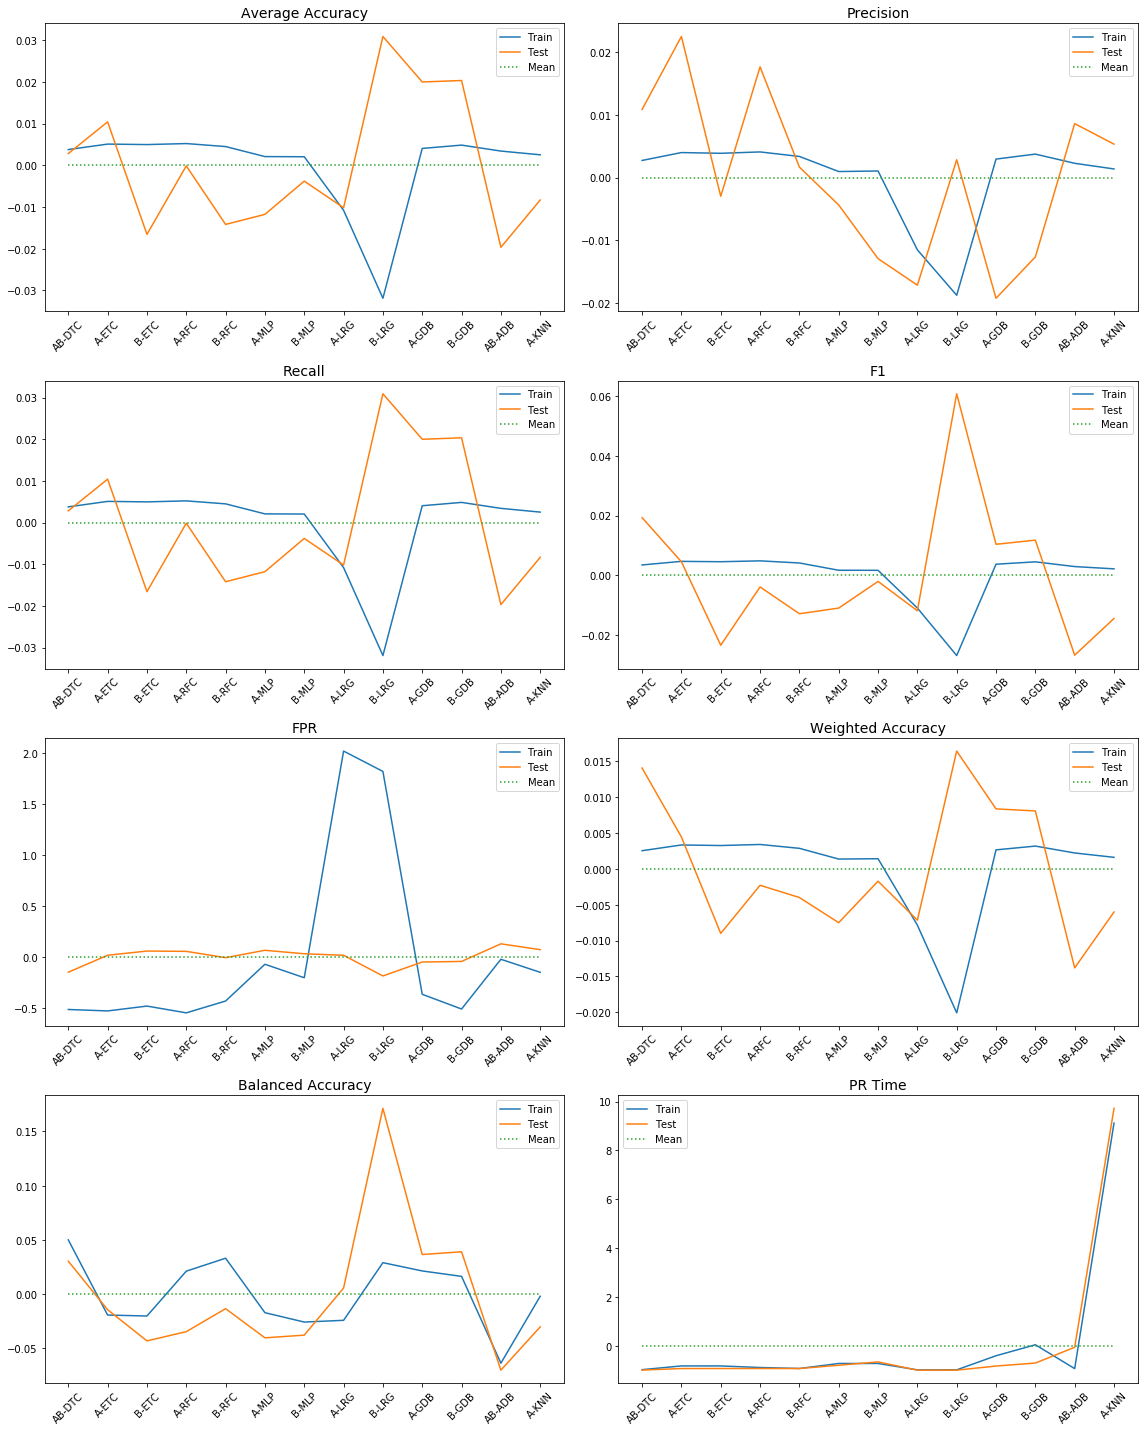

In [4]:
def plotClassifierMetrics(plotMetrics, plot_TR, plot_TS, clf_display_names, figname):

    TR_IResults = plot_LR.loc['S_Results']
    TS_IResults = plot_TS.loc['S_Results']

    plotIDX = 0
    fig = plt.subplots(figsize=(8 * 2, 5 * 4))
    
    for pm in plotMetrics:

        all_TR_clf_names = plot_TR.columns
        all_TS_clf_names = plot_TS.columns

        m_all_TR = np.empty([0,1], float)
        m_all_TS = np.empty([0,1], float)

        for cidx in range(len(all_TR_clf_names)):

            clf_TR_name = all_TR_clf_names[cidx]
            clf_TS_name = all_TS_clf_names[cidx]

            m_TR = LR_IResults.loc[clf_TR_name][pm][0]
            m_TS = TS_IResults.loc[clf_TS_name][pm][0]

            m_all_TR = np.append(m_all_TR, m_TR)
            m_all_TS = np.append(m_all_TS, m_TS)


        y_mean_TR = [np.mean(m_all_TR)]*len(all_TR_clf_names)
        y_mean_TS = [np.mean(m_all_TS)]*len(all_TS_clf_names)

        scaled_TR = m_all_TR / y_mean_TR - 1
        scaled_TS = m_all_TS / y_mean_TS - 1

        n_clfs = len(all_TR_clf_names)
        
        zero = [0]*n_clfs

        mtrL = [MCSTR_L_XS_Results[pm][0]/np.mean(m_all_TR) - 1]*n_clfs
        mtsL = [MCSTS_L_XS_Results[pm][0]/np.mean(m_all_TS) - 1]*n_clfs
        mtrO = [MCSTR_O_XS_Results[pm][0]/np.mean(m_all_TR) - 1]*n_clfs
        mtsO = [MCSTS_O_XS_Results[pm][0]/np.mean(m_all_TS) - 1]*n_clfs
 
        if pm == 'B_Accuracy': pm = 'Balanced Accuracy'
        if pm == 'W_Accuracy': pm = 'Weighted Accuracy'
        if pm == 'Accuracy': pm = 'Average Accuracy'


        ax = plt.subplot(4, 2, plotIDX + 1)
        
        ax.plot(all_TS_clf_names, scaled_TR, label = 'Train')
        ax.plot(all_TS_clf_names, scaled_TS, label = 'Test')
        ax.plot(all_TS_clf_names, zero, label='Mean', linestyle='dotted')
        
#         ax.plot(all_TS_clf_names, mtrL, label='L-MCS Train', linestyle='--')
#         ax.plot(all_TS_clf_names, mtsL, label='L-MCS Test', linestyle='--')
        
        
#         ax.plot(all_TS_clf_names, mtrO, label='O-MCS Train', linestyle='--')
#         ax.plot(all_TS_clf_names, mtsO, label='O-MCS Test', linestyle='--')
        
        tick_marks = np.arange(len(clf_display_names))

        plt.xticks(tick_marks, clf_display_names, rotation=45)
        #plt.ylabel('Variation')
        plt.title(pm, size = 14)
        plt.legend()  

        plotIDX += 1

    plt.tight_layout()      
    
    plt.savefig(figname + '.png')
    plt.show()
    
plotMetrics = TS_IResults[0].columns[np.r_[:5, 7, 8, 6]]

clf_display_names = ['AB-DTC', 'A-ETC', 'B-ETC', 'A-RFC', 'B-RFC', 'A-MLP', 
                     'B-MLP', 'A-LRG', 'B-LRG', 'A-GDB', 'B-GDB', 'AB-ADB', 'A-KNN']

drop_models = []
train_pd, test_pd = dropModels(drop_models, all_LR_Results, all_TS_Results)

# train_pd.loc['S_Results']['L-MCS'] = MCSTR_L_XS_Results
# test_pd.loc['S_Results']['L-MCS'] = MCSTS_L_XS_Results

# train_pd.loc['S_Results']['O-MCS'] = MCSTR_O_XS_Results
# test_pd.loc['S_Results']['O-MCS'] = MCSTS_O_XS_Results

plotClassifierMetrics(plotMetrics, train_pd, test_pd, clf_display_names, 'all_met_and_clf')

# clf_display_names = ['AB-DTC', 'A-ETC', 'B-ETC', 'A-RFC', 'B-RFC', 'A-MLP', 
#                      'B-MLP', 'A-LRG', 'A-GDB', 'B-GDB', 'AB-ADB']

# drop_models = ['a_knn', 'b_lrg']
# train_pd, test_pd = dropModels(drop_models, all_LR_Results, all_TS_Results)

# plotClassifierMetrics(plotMetrics, train_pd, test_pd, clf_display_names, 'all_met_outliers')


# Confusion Confusion Confusion

In [2]:
# borrowed code from: https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
# we use this instead of sk-learns builtin function bc it only works on data created insid sk-learn
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
   
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    fig, ax = plt.subplots(figsize=(5, 5))
    
    #plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]*100


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}%".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    ax.xaxis.tick_top()
    
    plt.savefig(title+'.png', bbox_inches='tight')
    plt.tight_layout()
    #plt.ylabel('Actual Class')
    #plt.xlabel('Predicted Class') # \naccuracy = {:0.4f}; error = {:0.4f}'.format(accuracy, misclass))
    
    #ax.set_xlabel('Predicted Class')   
    #ax.xaxis.set_label_position('top') 
    
    plt.show()

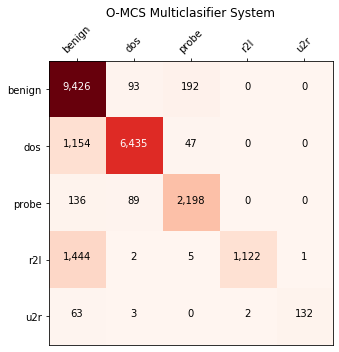

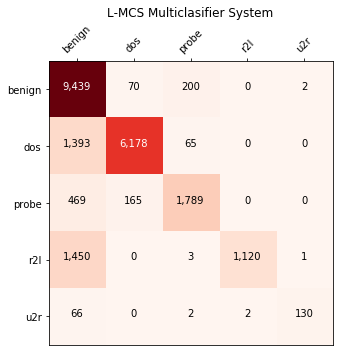

In [3]:

plot_confusion_matrix(MCSTS_O_XCM.to_numpy(), MCSTS_O_XCM.columns, 'O-MCS Multiclasifier System', plt.get_cmap('Reds'), False)
plot_confusion_matrix(MCSTS_L_XCM.to_numpy(), MCSTS_L_XCM.columns, 'L-MCS Multiclasifier System', plt.get_cmap('Reds'), False)



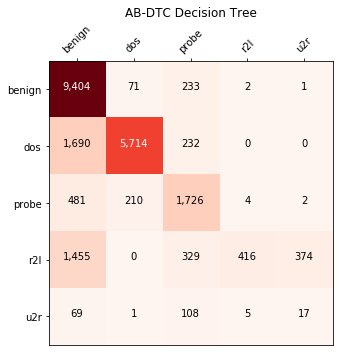

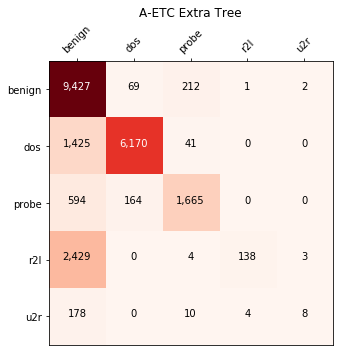

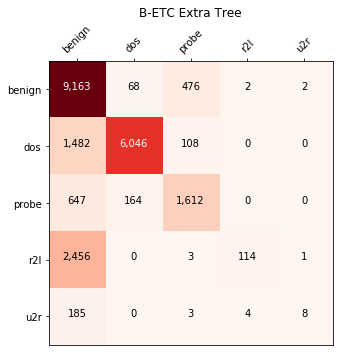

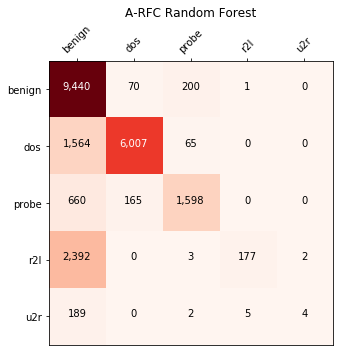

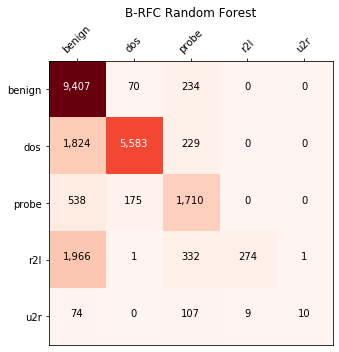

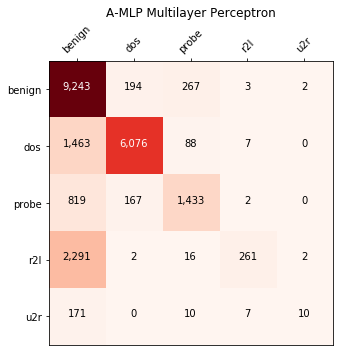

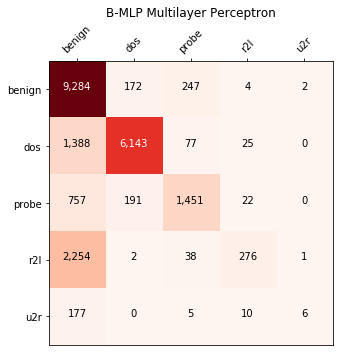

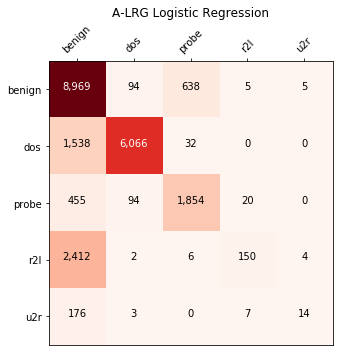

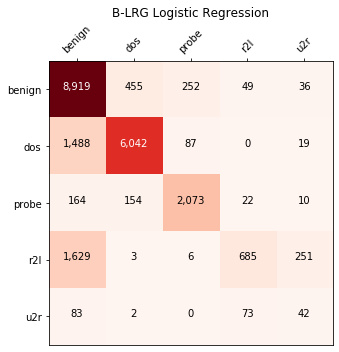

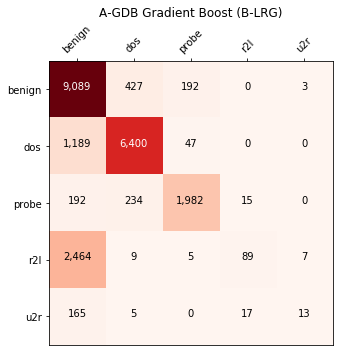

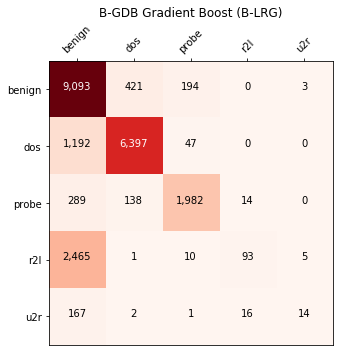

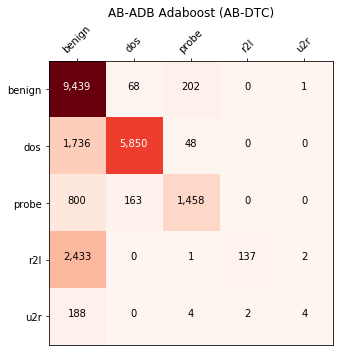

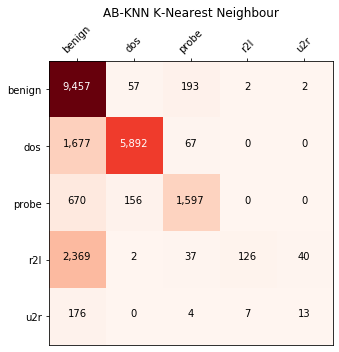

In [505]:
def plotAllCM(df):

    full_classifier_names = ['AB-DTC Decision Tree', 
                             'A-ETC Extra Tree', 
                             'B-ETC Extra Tree',
                             'A-RFC Random Forest',
                             'B-RFC Random Forest',
                             'A-MLP Multilayer Perceptron',
                             'B-MLP Multilayer Perceptron',
                             'A-LRG Logistic Regression',
                             'B-LRG Logistic Regression',
                             'A-GDB Gradient Boost (B-LRG)',
                             'B-GDB Gradient Boost (B-LRG)',
                             'AB-ADB Adaboost (AB-DTC)',
                             'AB-KNN K-Nearest Neighbour']
    
    df_results = df.copy()
    
    for idx, clf_name in fzip(df_results.columns):
        
        CM = df_results.loc['C_Results'].loc[clf_name]
        
        plot_confusion_matrix(CM.to_numpy(), CM.columns, full_classifier_names[idx], plt.get_cmap('Reds'), False)
        


plotAllCM(all_TS_Results)